                                                                                                                 
# MOA1 - ML project

## Drug sensitivity prediction & precision oncology

### Drug name: Irinotecan
### Cancer type: Colon Cancer

#### Authors: Bilge Elitok
#### Date: 28.12.2024

New ideas:

* A human breast cancer-derived xenograft and organoid platform for drug discovery and precision oncology - https://www.nature.com/articles/s43018-022-00337-6

* A single-cell analysis of breast cancer cell lines to study tumour heterogeneity and drug response - https://www.nature.com/articles/s41467-022-29358-6

* Pan-cancer study based on PDX models https://pdmr.cancer.gov/

## Table of contents
1.	[Introduction](#section_1)<br>
2.	[Environment and data preparation](#section_2)<br>
    2.1  [Importing necessary modules](#section_2.1)<br>
    2.2  [Loading the data](#section_2.2)<br>
    2.3  [Inspecting the contents of the datasets](#section_2.3)<br>
    2.4  [Visualizing gene expression profile of cancer cell lines (CCLE and GDSC)](#section_2.4)<br>
    2.5  [Transforming the targets into a categorical variable](#section_2.5)<br>
    2.6  [Splitting the CCLE dataset into train and test sets](#section_2.6)<br>
    2.7  [Checking/imputing missing values](#section_2.7)<br>
    2.8  [Scaling the data](#section_2.8)<br>
3.	[Exploratory analysis](#section_3) <br>
    3.1	[PCA of CCLE and GDSC mRNA data](#section_3.1) <br>
    3.2	[Collinearity of the features in CCLE mRNA training data](#section_3.2) <br>
4.  [Model training, validation and testing](#section_4)<br> 
    4.1	[Training classifiers on CCLE mRNA data and testing their accuracy ](#section_4.1) <br>
    4.2	[Analysis of all classifiers](#section_4.2) <br>
    4.3	[Training regressors on CCLE mRNA data and testing their performance](#section_4.3) <br>
    4.4	[Analysis of all regressors ](#section_4.4) <br>
5.	[Selecting biomarkers of drug sensitivity](#section_5) <br>
    5.1	[Compare feature importance using feature weights](#section_5.1) <br>
    5.2 [Feature importance in literature](#section_5.2) <br>
6.	[Clustering mRNA profiles of cancer patients](#section_6) <br>
    6.1	[Compare gene expression trends between patien subgroups and sensitive/resistant cancer cell lines](#section_6.1) <br>
7.  [Discussion](#section_6) <br>
8.	[References](#section_7) <br>

## 1. Introduction <a id="section_1"></a>

    The project investigates how gene expression data from cancer cell lines can predict patient responses to irinotecan, a chemotherapy drug. Using colon cancer cell line data, biomarkers related to irinotecan sensitivity were identified through regularization-based methods such as Ridge and ElasticNet regression. These biomarkers were then used to cluster colon cancer patient data, aiming to identify subgroups with distinct treatment responses. The results revealed that higher WRAP53 expression correlates with irinotecan sensitivity in certain patient clusters. Another candidate biomarker MAP3K4, once significant for cell line subgroups show no distinctive capability between colon adenocarcinoma patients, highlighting the gap between cancer models and patient data, as well as the importance of validating biomarkers discovered in cell lines on patient datasets for clinical applicability.

## 2. Environment and data preparation <a id="section_2"></a>

### 2.1. Importing necessary modules <a id="section_2.1"></a>

 pandas (pd): Data manipulation and analysis. (Example functions: DataFrame)  
• numpy (np): Numerical computations and array handling (Example functions: percentile).  
• random Python’s own random was imported for setting random seeds for reproducibility.  
• requests: Used for fetching gene names by ensembl IDs, through Ensembly API.  
• OS (os): File and path management (Example functions: path)  
• Matplotlib (plt): Visualization (Example functions: scatter)  
• Seaborn (sns): Data visualization and custom plotting (Example functions: heatmap)  
• SciPy (scipy): Statistical analysis (Example functions: shapiro)  
• requests: HTTP requests for fetching external data from Ensembl API.   (Example functions: get, json)  
• (Scikit-Learn): Machine learning models, data pre-processing, and evaluation (Example functions:  
PowerTransformer, SimpleImputer,GridsearchCV)  
• %matplotlib inline: Ensures plots displayed within the Jupyter Notebook  

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
%matplotlib inline

import seaborn as sns
import scipy

from scipy.stats import shapiro, skew
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.base import clone



In [2]:
import random
random.seed(42)  # Python's built-in random seed for reproducibility.

### 2.2 Loading the data <a id="section_2.2"></a>

In [ ]:
paths = [r".\ccle_irinotecan_mrna.csv",
         r".\test_irinotecan_mrna.csv",
         r".\ccle_irinotecan_muta.csv"
]

### 2.3 Inspecting the contents of the datasets <a id="section_2.3"></a>

In [4]:
def load_data(path_list, null_threshold, remove_columns = False):
    """Load data from paths and summarize key information.

    args
    path_list(list):        list of where .csv files are located
    null_threshold(float):  columns that has null value percentage exceeds this number will be returned
    remove_columns(boolean):specification of whether the columns that has null count above threshold should be removed

    returns
    List of the objects that store the input data
    Summary Table for the files.
    data stored in global dataframes object with removal of the columns if remove_columns = True.
    
    """
    dataframes         = {}
    dataframes_summary = []
    null_col_list      = []

    for path in path_list:
        # Extract file name without extension:
        file_name = os.path.splitext(os.path.basename(path))[0]

        # Convert to pandas DataFrame
        df = pd.read_csv(path)
        df.rename(columns={'Unnamed: 0': 'Cell_Line'}, inplace=True)

        # Gather data information
        row_count, column_count = df.shape[0], df.shape[1]
        null_count = df.isnull().sum().sum()  # Total null count
        null_columns = [(col, count) for col, count in df.isnull().sum().items() if count > 0]
        null_col_list.append(null_columns)

        #Return if the columns have duplicates:
        unique_count = df.columns.nunique()


        # Columns with more than the null threshold
        percentage_null = (df.isnull().sum() / len(df)) * 100
        columns_above_threshold = percentage_null[percentage_null > null_threshold]

        # Target column index
        target_column_idxs = []  # Initialize target column index list
        for col_idx, target_column in enumerate(df.columns):
            if 'target' in target_column.lower():
                target_column_idxs.append(f'with Target Column at index {col_idx}')

        # Save DataFrame and its summary
        dataframes[file_name] = df

        # Dynamic Variable Assignment for accesing dataframes outside the function.
        for name, df in dataframes.items():
            globals()[name] = df

        dataframes_summary.append({
            "File Name": file_name,
            "Row Count": row_count,
            "Column Count": column_count,
            "Number of Duplicate Columns?": int(len(df.columns) - unique_count),
            "Has Null Values": null_count > 0,
            "Total Null Count": null_count,
            f"Columns with more than {null_threshold}% missing": list(columns_above_threshold.index),
            "Target Column Index": target_column_idxs,
        })

    # Convert summaries to a DataFrame
    summary_df = pd.DataFrame(dataframes_summary)

    print(f'Your files are stored in the following objects: {list(dataframes.keys())}')

    return summary_df, null_col_list


In [5]:
summary_data, null_col_list = load_data(path_list=paths, null_threshold=30)

Your files are stored in the following objects: ['ccle_irinotecan_mrna', 'test_irinotecan_mrna', 'ccle_irinotecan_muta']


In [ ]:
summary_data

,File Name,Row Count,Column Count,Number of Duplicate Columns?,Has Null Values,Total Null Count,Columns with more than 30% missing,Target Column Index
0,ccle_irinotecan_mrna,309,496,0,True,1515,[],[with Target Column at index 495]
1,test_irinotecan_mrna,535,496,0,False,0,[],[with Target Column at index 495]
2,ccle_irinotecan_muta,293,64,0,False,0,[],[with Target Column at index 63]


Short description of the content of each dataset.

<font color='red'> The first column corresponds to cancer cell lines. They could be used as index since the datasets are uploaded as data.frame </font>

In [7]:
#ccle_mrna.drop(ccle_mrna.columns[0], axis=1, inplace=True)
#GDSC_data.drop(GDSC_data.columns[0], axis=1, inplace=True)

In [8]:
def plot_skewness_and_target_distribution(data, target_column):

    skew_values = data.drop(columns=[target_column]).apply(lambda x: skew(x.dropna()))
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
 
    sns.barplot(x=skew_values.index, y=skew_values.values, ax=axes[0], color='green')
    axes[0].set_title("Skewness of Features")
    axes[0].set_xlabel("Features")
    axes[0].set_ylabel("Skewness")
    axes[0].set_xticks('')
    
    sns.histplot(data[target_column], kde=True, ax=axes[1], bins=30, color='green')
    axes[1].set_title(f"Distribution of {target_column}")
    axes[1].set_xlabel(target_column)
    axes[1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()


Sensitivity Class Discretization

In [9]:
#Define function to encode target values into three classes.
#2:Sensitive 
#1:Mild
#0:Resistant

def sort_sensitivity_class(data):

    auc_values = data['target']

    lower_percentile = np.percentile(auc_values, 33) #until 33 percent
    higher_percentile = np.percentile(auc_values, 66) #middle 33


    print(f'Lower Percentile (33%): {lower_percentile}')
    print(f'Higher Percentile (66%): {higher_percentile}')

    sensitivity_classes    = []


    for auc_val in auc_values:
        if auc_val >= higher_percentile:
            sensitivity_classes.append(2) #this corresponds to top 33%

        elif auc_val < lower_percentile:
            sensitivity_classes.append(0) #bottom 33%

        else:
            sensitivity_classes.append(1) #Everything inbetween are categorized as mild values.


    data['sensitivity'] = sensitivity_classes #Append results as a new col.


    #sorted_data = data.sort_values(by='sensitivity', ascending = True)

    return data #Return the numerical encodings of sensitivity in 'Sensitivity Column'

In [10]:
#Sort the cell lines for visualization of them with overlaying bars in heatmap.
ccle = sort_sensitivity_class(ccle_irinotecan_mrna)
test = sort_sensitivity_class(test_irinotecan_mrna)

Lower Percentile (33%): 0.3350664596321693
Higher Percentile (66%): 0.4495397607300847
Lower Percentile (33%): 0.07357546396573549
Higher Percentile (66%): 0.14884462435855306


In [ ]:
ccle

,Cell_Line,ENSG00000005243,ENSG00000005893,ENSG00000006625,ENSG00000007516,ENSG00000008018,ENSG00000011260,ENSG00000011304,ENSG00000012822,ENSG00000013288,...,ENSG00000113638,ENSG00000159210,ENSG00000154016,ENSG00000153933,ENSG00000083223,ENSG00000037042,ENSG00000125148,ENSG00000164093,target,sensitivity
0,22Rv1,5.036982,9.375183,12.202992,5.194733,12.799690,11.047020,11.094295,6.764623,7.910099,...,NaN,9.333365,3.879292,4.002511,7.071933,6.905976,13.235390,7.251851,0.506325,2
1,5637,5.492048,10.127392,11.169841,4.691951,13.094605,12.142156,11.766449,6.759684,6.359368,...,6.813929,10.659362,4.099227,4.206460,7.251208,7.129720,14.160232,7.157888,0.559540,2
2,639V,5.954988,9.811754,11.161464,4.860137,12.953396,11.564391,12.248614,6.806178,7.378121,...,8.555448,9.524457,4.234961,4.886166,NaN,7.375606,NaN,3.469450,0.555838,2
3,697,5.149461,6.692191,11.159243,4.680283,12.692533,11.607299,12.090947,6.693558,5.725620,...,7.967863,9.137397,5.248499,4.729264,6.652496,6.057627,12.371309,NaN,0.652102,2
4,769-P,4.974151,9.698471,10.809274,5.022576,13.112315,11.117219,11.545802,6.600233,7.521938,...,6.681667,NaN,4.106126,3.747689,6.979751,6.257296,14.156705,5.936338,0.297615,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,WM793,5.724802,11.166994,11.587509,4.689159,12.694640,10.938197,11.653586,6.454600,8.438735,...,7.048537,9.529447,3.794915,3.833483,7.330847,7.644292,14.540269,4.814124,0.564236,2
305,WM88,5.131424,11.304964,11.504975,4.850526,12.847779,10.868192,11.136354,6.472488,7.406638,...,8.013575,9.514342,3.716336,3.705488,6.945092,6.958771,14.324426,3.319121,0.446922,1
306,WM983B,5.958762,11.639255,11.104314,5.101347,11.957749,11.755205,11.100674,6.596822,6.891657,...,NaN,10.139468,4.241060,3.875019,6.988238,6.135988,14.339562,3.518887,0.179139,0
307,YKG-1,6.960714,12.510198,10.951013,4.648087,12.962480,11.471734,10.805106,6.802548,8.280874,...,7.232940,9.539015,3.789897,4.162329,7.374182,7.478170,14.226196,NaN,0.215269,0


### 2.4 Visualizing gene expression profile of cancer cell lines (CCLE and GDSC) <a id="section_2.4"></a>

* Visualize predictors and the target variables
* Justify your choice of selected visualization tools. Why am I using it?
* Include your interpretation of figures/tables generated and what conclusion is drawn from them 

In [ ]:
def heatmap_sensitivity(data):
    
    sensitivity_colors = {0:'red', 1: 'yellow', 2: 'green'}

    fig, ax = plt.subplots(figsize=(25, 8))
    plt.subplots_adjust(left=0.25, right=0.5, top=0.95, bottom=0.25) #Add padding


    sns.heatmap(data.drop(columns=['sensitivity', 'Cell_Line', 'target','sensitivity_categorical', 'sensitivity_categories'],
                          errors='ignore'),
                          annot=False,
                          cmap='coolwarm',
                          cbar_kws={'label': 'Gene Expression'},
                          xticklabels=False,
                          yticklabels=False)

    #Overlay sensitivity maps onto heatmap.
    for i, sensitivity in enumerate(data['sensitivity']):
        ax.add_patch(plt.Rectangle((-0.5, i), 5, 1, color=sensitivity_colors[sensitivity]))


    legend_elements = [Line2D([0], [0], color='green', lw=4, label='Sensitive'),
                    Line2D([0], [0], color='yellow', lw=4, label='Mild'),
                    Line2D([0], [0], color='red', lw=4, label='Resistant')]

    plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)

    plt.title(f'Heatmap of Gene Expression with Sensitivity/Resistance Bars')
    plt.show()


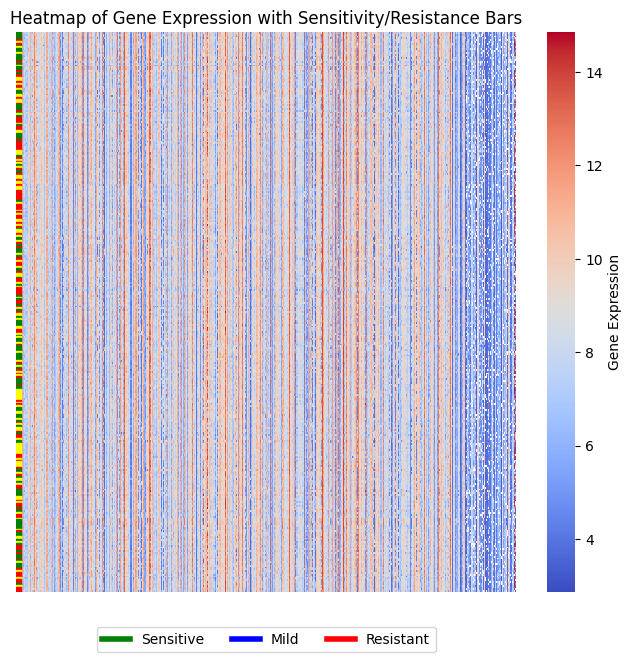

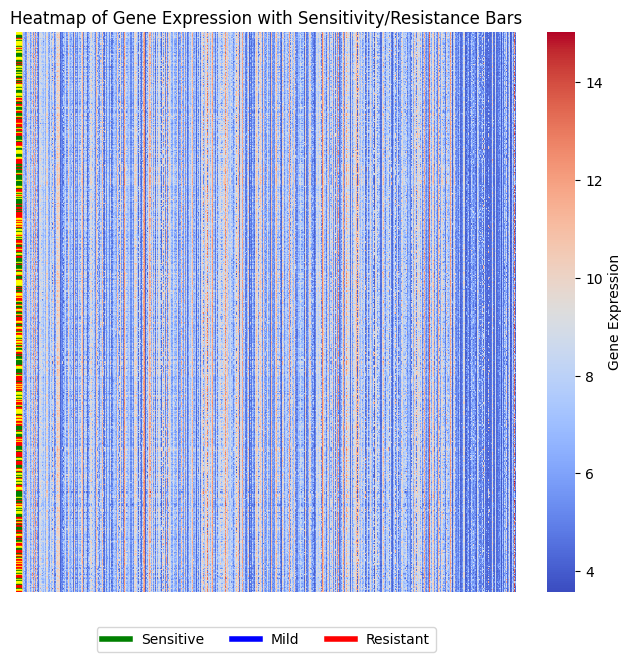

In [13]:
heatmap_sensitivity(ccle)
heatmap_sensitivity(test)

### 2.5 Transforming the targets into a categorical variable <a id="section_2.5"></a>

* The target AUC scores are continuous. Thus, for the upcoming classification task, the target variable must be discretized into 2 separate categories: high and low sensitivity AUC scores. As there is no clear treshold for high and low sensitivity, the separation between the two classes can be arbitrary. 

* Show the count of cancer cell lines with low and high sensitivitiy in each dataset.

In [14]:
def count_sensitivity_categories(data):

    sensitivity_counts = data['sensitivity'].value_counts()
    sensitivity_labels = {0: 'Resistant', 1: 'Mild', 2: 'Sensitive'}
    labeled_counts = sensitivity_counts.rename(index=sensitivity_labels)

    return labeled_counts

In [15]:
counts_ccle = count_sensitivity_categories(ccle)
counts_test = count_sensitivity_categories(test)
sensitivity_labels = {0: 'Resistant', 1: 'Mild', 2: 'Sensitive'}

counts_summary = pd.DataFrame({
    'Category': list(sensitivity_labels.values()),
    'CCLE'    : list(counts_ccle),
    'CDSE'    : list(counts_test)
})

counts_summary #Also helps us check the categorization of the target.

,Category,CCLE,CDSE
0,Resistant,105,182
1,Mild,102,177
2,Sensitive,102,176


### 2.6 Splitting the CCLE dataset into train and test sets <a id="section_2.6"></a>

Please note that the test set here is meant for internal validation, so withouth using the external dataset (GDSC). 

You can also do the splitting by using the cross-validation. In this case you will implement a nested cross validation (see coding exercises of the practical section focusing on regression tasks).

### 2.7 Checking/imputing missing values

In this case, is it better to remove the observation with missing values or imputing them?

### 2.8 Scaling the data <a id="section_2.8"></a>

* The data should be scaled for principal component analysis and for better performance on the models. 

* Remember to prevent information leakage (especially when scaling data).

* Some features (including the target variable) are skewed. During the first practical session we have explored some of the techniques to reduce right and left skewness. So, you can apply both scaling and transformation (for certain features). But this is not mandatory.
  
* Moreover, some transformation techniques such as *log* and *square root transformations* operate directly on the feature values and do not depend on the dataset’s distribution (e.g., mean or variance) - so no need to worry about data leakage, unless you want to apply *box-cox transformations*.

* Remember tha linear models assume that the errors are independent and normally distributed, with constant variance (homoscedasticity).

In [16]:
ccle

,Cell_Line,ENSG00000005243,ENSG00000005893,ENSG00000006625,ENSG00000007516,ENSG00000008018,ENSG00000011260,ENSG00000011304,ENSG00000012822,ENSG00000013288,...,ENSG00000113638,ENSG00000159210,ENSG00000154016,ENSG00000153933,ENSG00000083223,ENSG00000037042,ENSG00000125148,ENSG00000164093,target,sensitivity
0,22Rv1,5.036982,9.375183,12.202992,5.194733,12.799690,11.047020,11.094295,6.764623,7.910099,...,NaN,9.333365,3.879292,4.002511,7.071933,6.905976,13.235390,7.251851,0.506325,2
1,5637,5.492048,10.127392,11.169841,4.691951,13.094605,12.142156,11.766449,6.759684,6.359368,...,6.813929,10.659362,4.099227,4.206460,7.251208,7.129720,14.160232,7.157888,0.559540,2
2,639V,5.954988,9.811754,11.161464,4.860137,12.953396,11.564391,12.248614,6.806178,7.378121,...,8.555448,9.524457,4.234961,4.886166,NaN,7.375606,NaN,3.469450,0.555838,2
3,697,5.149461,6.692191,11.159243,4.680283,12.692533,11.607299,12.090947,6.693558,5.725620,...,7.967863,9.137397,5.248499,4.729264,6.652496,6.057627,12.371309,NaN,0.652102,2
4,769-P,4.974151,9.698471,10.809274,5.022576,13.112315,11.117219,11.545802,6.600233,7.521938,...,6.681667,NaN,4.106126,3.747689,6.979751,6.257296,14.156705,5.936338,0.297615,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,WM793,5.724802,11.166994,11.587509,4.689159,12.694640,10.938197,11.653586,6.454600,8.438735,...,7.048537,9.529447,3.794915,3.833483,7.330847,7.644292,14.540269,4.814124,0.564236,2
305,WM88,5.131424,11.304964,11.504975,4.850526,12.847779,10.868192,11.136354,6.472488,7.406638,...,8.013575,9.514342,3.716336,3.705488,6.945092,6.958771,14.324426,3.319121,0.446922,1
306,WM983B,5.958762,11.639255,11.104314,5.101347,11.957749,11.755205,11.100674,6.596822,6.891657,...,NaN,10.139468,4.241060,3.875019,6.988238,6.135988,14.339562,3.518887,0.179139,0
307,YKG-1,6.960714,12.510198,10.951013,4.648087,12.962480,11.471734,10.805106,6.802548,8.280874,...,7.232940,9.539015,3.789897,4.162329,7.374182,7.478170,14.226196,NaN,0.215269,0


In [17]:
X = ccle.filter(like='ENSG', axis=1)
y = ccle['target']

#ccle = pd.concat([X, y], axis=1)
ccle

,Cell_Line,ENSG00000005243,ENSG00000005893,ENSG00000006625,ENSG00000007516,ENSG00000008018,ENSG00000011260,ENSG00000011304,ENSG00000012822,ENSG00000013288,...,ENSG00000113638,ENSG00000159210,ENSG00000154016,ENSG00000153933,ENSG00000083223,ENSG00000037042,ENSG00000125148,ENSG00000164093,target,sensitivity
0,22Rv1,5.036982,9.375183,12.202992,5.194733,12.799690,11.047020,11.094295,6.764623,7.910099,...,NaN,9.333365,3.879292,4.002511,7.071933,6.905976,13.235390,7.251851,0.506325,2
1,5637,5.492048,10.127392,11.169841,4.691951,13.094605,12.142156,11.766449,6.759684,6.359368,...,6.813929,10.659362,4.099227,4.206460,7.251208,7.129720,14.160232,7.157888,0.559540,2
2,639V,5.954988,9.811754,11.161464,4.860137,12.953396,11.564391,12.248614,6.806178,7.378121,...,8.555448,9.524457,4.234961,4.886166,NaN,7.375606,NaN,3.469450,0.555838,2
3,697,5.149461,6.692191,11.159243,4.680283,12.692533,11.607299,12.090947,6.693558,5.725620,...,7.967863,9.137397,5.248499,4.729264,6.652496,6.057627,12.371309,NaN,0.652102,2
4,769-P,4.974151,9.698471,10.809274,5.022576,13.112315,11.117219,11.545802,6.600233,7.521938,...,6.681667,NaN,4.106126,3.747689,6.979751,6.257296,14.156705,5.936338,0.297615,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,WM793,5.724802,11.166994,11.587509,4.689159,12.694640,10.938197,11.653586,6.454600,8.438735,...,7.048537,9.529447,3.794915,3.833483,7.330847,7.644292,14.540269,4.814124,0.564236,2
305,WM88,5.131424,11.304964,11.504975,4.850526,12.847779,10.868192,11.136354,6.472488,7.406638,...,8.013575,9.514342,3.716336,3.705488,6.945092,6.958771,14.324426,3.319121,0.446922,1
306,WM983B,5.958762,11.639255,11.104314,5.101347,11.957749,11.755205,11.100674,6.596822,6.891657,...,NaN,10.139468,4.241060,3.875019,6.988238,6.135988,14.339562,3.518887,0.179139,0
307,YKG-1,6.960714,12.510198,10.951013,4.648087,12.962480,11.471734,10.805106,6.802548,8.280874,...,7.232940,9.539015,3.789897,4.162329,7.374182,7.478170,14.226196,NaN,0.215269,0


In [18]:
def show_distributions(data):

    gaussian_features     = []
    non_gaussian_features = []

    for col in data.filter(like='ENSG', axis=1):
        W_score, p_val = shapiro(data[col])
        if p_val < 0.05:
            non_gaussian_features.append(col)

        else:
            gaussian_features.append(col)

    n_gaussian, n_ng = len(gaussian_features), len(non_gaussian_features)

    print(f'There are {n_gaussian} Gaussian columns\nAnd there are {n_ng} non-Gaussian Columns.')

    #Return the categorized columns for data transformations.
    return gaussian_features, non_gaussian_features 

In [19]:
show_distributions(test)

There are 99 Gaussian columns
And there are 395 non-Gaussian Columns.


(['ENSG00000006625',
  'ENSG00000013288',
  'ENSG00000049541',
  'ENSG00000051108',
  'ENSG00000069248',
  'ENSG00000070761',
  'ENSG00000070814',
  'ENSG00000071994',
  'ENSG00000074356',
  'ENSG00000079246',
  'ENSG00000083635',
  'ENSG00000085511',
  'ENSG00000086061',
  'ENSG00000087087',
  'ENSG00000088298',
  'ENSG00000097021',
  'ENSG00000100479',
  'ENSG00000102316',
  'ENSG00000102871',
  'ENSG00000103502',
  'ENSG00000105202',
  'ENSG00000106344',
  'ENSG00000107949',
  'ENSG00000108064',
  'ENSG00000108578',
  'ENSG00000111142',
  'ENSG00000111540',
  'ENSG00000112029',
  'ENSG00000112110',
  'ENSG00000112592',
  'ENSG00000113048',
  'ENSG00000115484',
  'ENSG00000117697',
  'ENSG00000120253',
  'ENSG00000120438',
  'ENSG00000125450',
  'ENSG00000125656',
  'ENSG00000129351',
  'ENSG00000130254',
  'ENSG00000130713',
  'ENSG00000130724',
  'ENSG00000130935',
  'ENSG00000132323',
  'ENSG00000132963',
  'ENSG00000133119',
  'ENSG00000134758',
  'ENSG00000135476',
  'ENSG000001

In [20]:
import random

def k_folds_split(dataset, k, seed=42):
    
    random.seed(seed)
    
    dataset_splits = []
    df_copy = dataset.copy() 
    fold_size = int(len(df_copy) / k)

    df_copy = df_copy.sample(frac=1, random_state=seed).reset_index(drop=True)
    

    for i in range(k):
        start_idx = i * fold_size
        end_idx = start_idx + fold_size
        fold = df_copy.iloc[start_idx:end_idx].values.tolist()
        dataset_splits.append(np.asarray(fold))

    return dataset_splits

In [21]:
def cv(dataset, model, k):

    """ 
    k-fold cross validation with imputation, scaling and transformation.
    """
    #Arrange preprocessors
    imp = SimpleImputer()
    pt = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)


    #Arrange inputs:
    X = dataset.filter(like='ENSG', axis=1)
    y = dataset['target']

    dataset = pd.concat([X, y], axis=1)

    folds = k_folds_split(dataset, k)
    scores = []

    for i in range(k):

        validation_fold = folds[i] #remaining folds will be used as training set
        
        training_folds = np.concatenate([fold for j, fold in enumerate(folds) if j != i ], axis=0) 
        #decide a fold j is a training fold if j is not same as the i, validation fold.

        #train_test_split
        X_train_cv, y_train_cv = training_folds[:,:-1], training_folds[:, -1] #the last row, target row
        X_val_cv, y_val_cv = validation_fold[:,:-1], validation_fold[:,-1]

        #Fit Preprocessors on training data
        #Imputer should be applied separately within each fold to prevent data leakage.
        imp.fit(X_train_cv)

        X_train_imputed = imp.transform(X_train_cv)
        X_val_imputed = imp.transform(X_val_cv)
        
        #Retain the feature names on the dataframe, and pass them to the transformer.
        X_train_imputed_df = pd.DataFrame(X_train_imputed, columns=X.columns)
        X_val_imputed_df = pd.DataFrame(X_val_imputed, columns=X.columns)

        #Transformation
        pt.fit(X_train_imputed_df)

        X_train_transformed = pt.transform(X_train_imputed_df)
        X_val_transformed = pt.transform(X_val_imputed_df)

        model.fit(X_train_transformed, y_train_cv)

        y_predict = model.predict(X_val_transformed)

        mse = mean_squared_error(y_val_cv, y_predict)
        scores.append(mse)
        
    return np.mean(scores)

In [22]:
from sklearn.linear_model import Ridge
model = Ridge()
score = cv(dataset=ccle, model=model, k=10)
print("Average MSE score :", score)


Average MSE score : 0.01992410762064475


## 3. Exploratory analysis <a id="section_3"></a>

This section should contain additional visualization of the data, including principal component analysis and correlations between the features.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

### 3.1 PCA of CCLE and GDSC mRNA data <a id="section_3.1"></a>

First, apply PCA before removing collinear features.

In [24]:
#Plot PCA of dataset using target discretization function

def plot_pca(dataset, n_components, mode):
    #Initialize PCA-only functions
    scaler_pca = StandardScaler()
    imp_pca = SimpleImputer()
    pca = PCA(n_components=n_components)

    if mode == 'discrete':
        dataset = sort_sensitivity_class(dataset)
        y_pca = dataset['sensitivity']
        colors = {0:'red', 1: 'yellow', 2: 'green'}
        class_labels = {0: 'Resistant', 1: 'Mild', 2: 'Sensitive'}
        
    elif mode == 'continuous':
        y_pca = dataset['target']
    else:
        print('Invalid mode input')


    #Keep Results
    pca_results = []

    #Declaring it global to use CCLE mRNA training data for the next step: Collinearity Assesment
    global X_tr_pca
    #Arrange inputs for PCA
    X_pca = dataset.filter(like='ENSG', axis=1)

    #1.Split
    X_tr_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2)

    #2.Imputation
    #Imputer should be applied separately within each fold to prevent data leakage.
    X_tr_imp = imp_pca.fit_transform(X_tr_pca)
    X_test_imp = imp_pca.transform(X_test_pca)

    #3.Scaling
    X_tr_sc = scaler_pca.fit_transform(X_tr_imp)
    X_test_sc = scaler_pca.transform(X_test_imp)

    #4. Apply PCA for Visualization,  not for transformation.
    X_train_final = pca.fit_transform(X_tr_sc)

    #Print Findings
    print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")
    print(f"Total Explained Variance: {pca.explained_variance_ratio_.sum()}")

    pca_results.append(X_train_final)

    #plotting Explained Variance Ratio and First Two Principle Components side by side.
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))

    #Explained variance ratio plot from PS4.
    axs[0].scatter(x=[i+1 for i in range(len(pca.explained_variance_ratio_))],
               y=pca.explained_variance_ratio_,
               s = 200,
               color='orange',
               edgecolor='k')
    axs[0].set_xticks([i+1 for i in range(len(pca.explained_variance_ratio_))])
    axs[0].set_title("Explained variance ratio of the \nfitted principal component vector\n")
    axs[0].set_xlabel('Principal Components')
    axs[0].set_ylabel('Explained Variance Ratio')

    if mode == 'discrete':
        for sensitivity_class in class_labels.keys():
            mask = y_train_pca == sensitivity_class
            axs[1].scatter(X_train_final[mask, 0], X_train_final[mask, 1],
                           label=class_labels[sensitivity_class],
                           color=colors[sensitivity_class], edgecolor='k', alpha=0.7)
        axs[1].legend(title='Sensitivity Classes', loc='best')

    elif mode == 'continuous':
        scatter = axs[1].scatter(X_train_final[:, 0], X_train_final[:, 1],
                                 c=y_train_pca, cmap='viridis', edgecolor='k', alpha=0.7)
        fig.colorbar(scatter, ax=axs[1], label='Target')  # Continuous colorbar

    #Plotting first two Principal Components.
    axs[1].set_title('Class Separation on Training Data\nusing First Two Principal Components')
    axs[1].set_xlabel('Principal Component 1')
    axs[1].set_ylabel('Principal Component 2')


    plt.tight_layout()
    plt.show()




Lower Percentile (33%): 0.3350664596321693
Higher Percentile (66%): 0.4495397607300847
Explained Variance Ratio: [0.23888499 0.06352957 0.03460746 0.02903126 0.02718558 0.02218143
 0.02098459 0.01868549 0.01800563 0.01476608]
Total Explained Variance: 0.4878620764300826


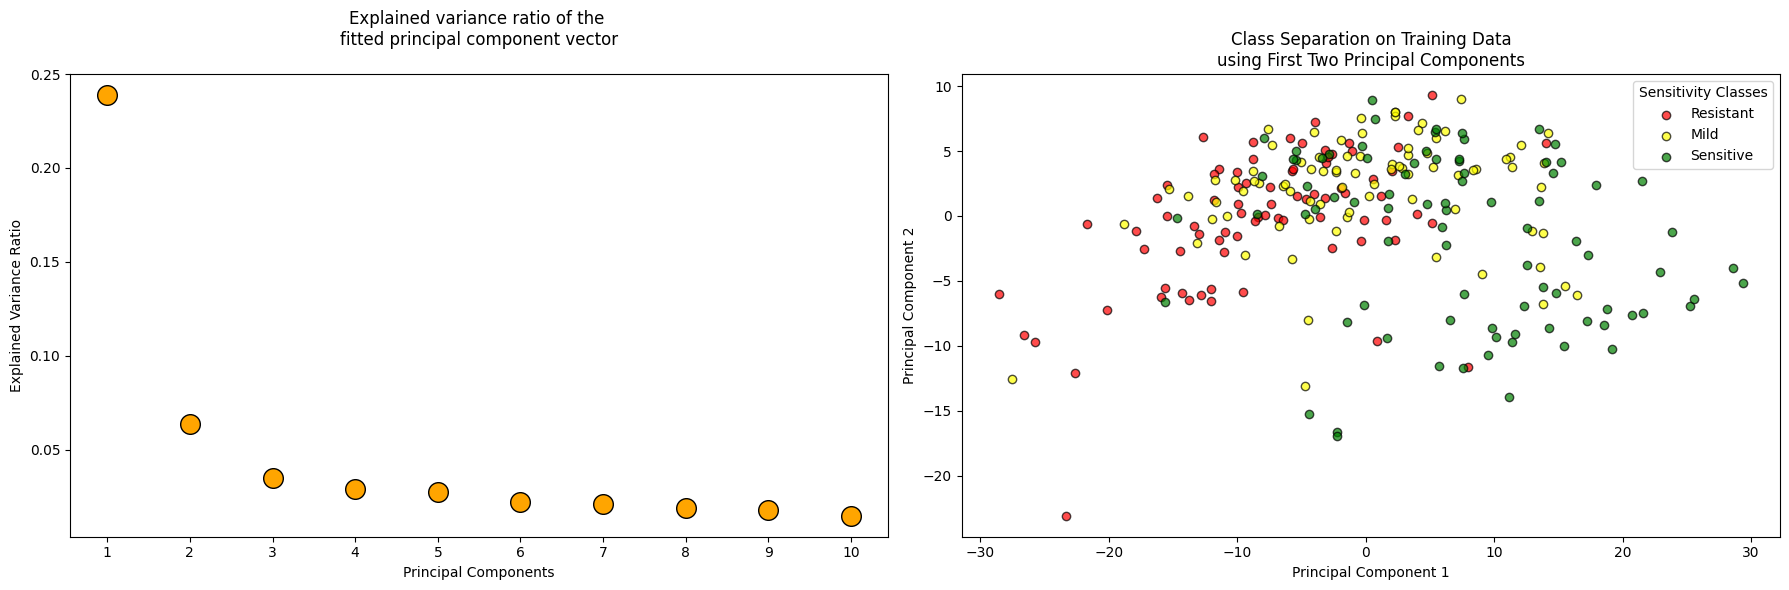

In [25]:
plot_pca(ccle, n_components=10, mode='discrete')

### 3.2 Collinearity of the features in CCLE mRNA training data <a id="section_3.3"></a>

Perform multicollinearity analysis to assess the dependence between two or more features, where some features can be expressed as a linear combination of others. Multicollinearity poses challenges for certain models, particularly those relying on coefficients to explain feature contributions (e.g., linear regression). It makes it harder to determine which features capture the patterns in the data, as they are interrelated. This can result in unreliable coefficients or feature importances and instability in the model, as small changes in one coefficient can disproportionately affect others. For tasks like extracting relevant features as biomarkers, multicollinearity is a significant issue.

There are two basic techniques: 

* **correlation plot** which can be used to visualize the relationships between numerical features, making it easier to spot highly correlated features.
* **Variance Inflation Factor (VIF)** quantifies how much a feature is linearly correlated with other features in a dataset. High VIF values indicate multicollinearity.

To address multicollinearity, you can either remove features with high VIF to improve interpretability or use robust methods like regularization (e.g., Ridge, Lasso, Elastic Net) or tree-based models that can handle multicollinearity effectively.

<Axes: title={'center': 'Correlation Plot of the Features in the GDSC Set'}>

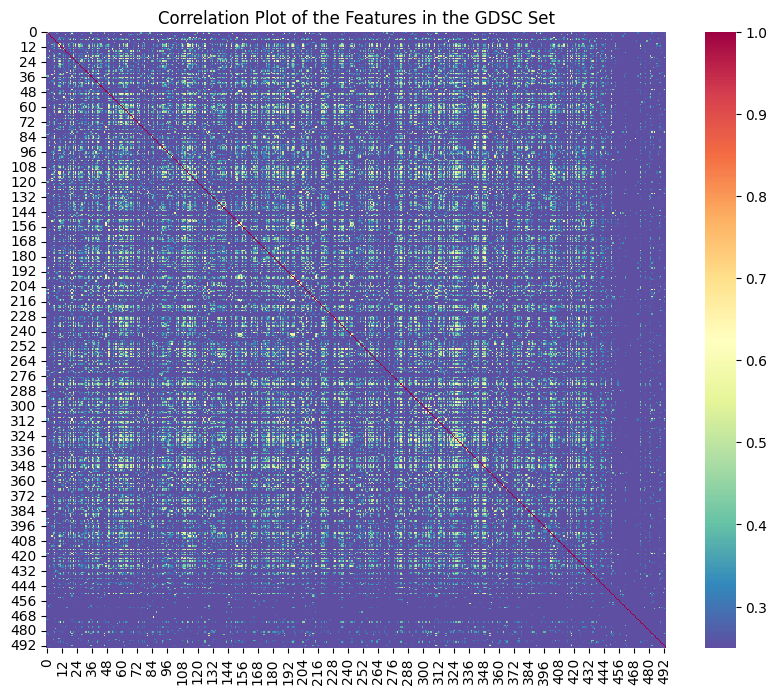

In [26]:
#Lets use correlation to indicate colinearity. Adapted from PS4
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_train_multicol = X_tr_pca
X_train_multicol = X_train_multicol.apply(lambda col: col.fillna(col.mean()), axis=0)

cor=np.corrcoef(X_train_multicol.T)
plt.figure(figsize=(10, 8))
plt.title('Correlation Plot of the Features in the GDSC Set')
axis_labels = X_train_multicol.columns
sns.heatmap(cor, vmin=0.25, vmax=1, cmap=plt.cm.Spectral_r)#, 
            #xticklabels=x_axis_labels, yticklabels=x_axis_labels)

In [27]:
lower_triangle = cor[np.tril_indices(cor.shape[0], k=-1)]

# Compute statistics from lower triangluar
mean_corr = np.mean(lower_triangle)
std_corr = np.std(lower_triangle)
within_range = np.sum((lower_triangle > -0.5) & (lower_triangle < 0.5))
total_coefficients = len(lower_triangle)
proportion_within_range = within_range / total_coefficients

print(f"The average correlation coefficient was r = {mean_corr:.2f} ± {std_corr:.2f}, ")
print(f"with {proportion_within_range * 100:.0f}% of the coefficients within the range [-0.5, 0.5].")

plt.show()


The average correlation coefficient was r = 0.09 ± 0.24, 
with 97% of the coefficients within the range [-0.5, 0.5].


In [28]:
nan_counts = ccle.isna().sum()
columns_with_nans = nan_counts[nan_counts > 0]
print(columns_with_nans.keys())


Index(['ENSG00000198046', 'ENSG00000095485', 'ENSG00000115107',
       'ENSG00000227779', 'ENSG00000106123', 'ENSG00000174684',
       'ENSG00000160957', 'ENSG00000088367', 'ENSG00000198742',
       'ENSG00000232931', 'ENSG00000217085', 'ENSG00000023041',
       'ENSG00000105726', 'ENSG00000124466', 'ENSG00000135114',
       'ENSG00000141449', 'ENSG00000106070', 'ENSG00000095585',
       'ENSG00000008405', 'ENSG00000248848', 'ENSG00000128262',
       'ENSG00000104974', 'ENSG00000109472', 'ENSG00000113196',
       'ENSG00000188937', 'ENSG00000105221', 'ENSG00000171206',
       'ENSG00000118257', 'ENSG00000042813', 'ENSG00000149100',
       'ENSG00000142609', 'ENSG00000114790', 'ENSG00000095015',
       'ENSG00000138111', 'ENSG00000142784', 'ENSG00000151475',
       'ENSG00000144635', 'ENSG00000173638', 'ENSG00000007384',
       'ENSG00000171161', 'ENSG00000135052', 'ENSG00000169676',
       'ENSG00000113638', 'ENSG00000159210', 'ENSG00000154016',
       'ENSG00000153933', 'ENSG000000832

## 4. Model training, validation and testing <a id="section_4"></a>

* Combine grid search with cross validation to perform hyperparameter tuning within the CCLE dataset. 

* Then, use the GDSC dataset as external validation set.

* Report for each selected evaluation metric (e.g. AUC-ROC for classification and MSE/R2 for regression) the evaluation score obtained on the training set, test set, and the external GDSC dataset.

* Comment on the possibility of overfitting or underfitting cases.

* The cross validation for hyperparameter tuning will return (mean and std in training/test accuracies for the best hyperparameters)

* Standard deviation in training/test accuracies can be used to further investigate overfitting and evaluate model stability. 

Below, the first version of the KFold_CV was first defined for classification. Then for the step 4, it was improved to be used both for classification and regression cases.

Custom implementation of nested_cv has the following core structure:
1. Filter Gene expression columns by 'ENSG' 
2. Define the nature of the target.
    - If classfication, use sensitivity categories.
    - If regression, use continuos values in target column.
3. Specify the structure of outer evaluation loop.
    - Split one dataset to inner loops and outer evaluation loop. 
    OR  
    - Use GDSC as the input for outer evaluation loop.
4. Split inner loops into training and evaluation loop.
5. Fit Simple Imputer and Yeo-Johnson Transformer in inner training subset.
6. Impute-Transform-Standardize inner training subset.
7. Impute-Transform-Standardize inner evaluation subset.
8. Train model on preprocessed data.
9. Return models and performance metrics for each fold.
10. Pass best model to outer loop.
11. Evaluate best model on outer loop.


### KFold Class defined for fold-wise Splitting, Imputation, Transformation and Scaling to prevent data leakage

In [29]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet

In [30]:
class KFold_CV:
    def __init__(self, k, model, param_grid=None, name="k_fold_cv"):
        self.k = k
        self.model = model
        self.param_grid = param_grid
        self.name = name

    def evaluate(self, training_dataset, testing_dataset, verbose=True):
        fit_results = self.fit(training_dataset, verbose)

        test_X = testing_dataset.filter(like='ENSG', axis=1)
        test_y = testing_dataset['target']

        imp = SimpleImputer(strategy='median')
        pt = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)

        imp.fit(test_X)
        test_X_imputed = imp.transform(test_X)

        pt.fit(test_X_imputed)
        test_X_transformed = pt.transform(test_X_imputed)

        test_X_transformed_df = pd.DataFrame(test_X_transformed)

        test_predictions = self.best_model.predict(test_X_transformed_df)
        test_mse = mean_squared_error(test_y, test_predictions)

        if verbose:
            print(f"Validation MSE: {test_mse}")

        coefficients = self.get_feature_importances(self.best_model)

        return {
            'cross_validation_results': fit_results,
            'external_test_mse': test_mse,
            'coefficients': coefficients 
        }

    def fit(self, dataset, verbose=True):
        self.train_mse_scores = []
        self.test_mse_scores = []
        self.trained_models = []
        self.coefficients = []

        X = dataset.filter(like='ENSG', axis=1)
        y = dataset['target']

        folds_X = np.array_split(X, self.k)
        folds_y = np.array_split(y, self.k)

        for test_fold_i in range(self.k):
            if verbose:
                print(f"{self.name} fold {test_fold_i+1}: ------")

            X_val = folds_X[test_fold_i]
            y_val = folds_y[test_fold_i]
            y_val = pd.DataFrame(y_val)

            X_train = pd.concat([folds_X[i] for i in range(self.k) if i != test_fold_i])
            y_train = pd.concat([folds_y[i] for i in range(self.k) if i != test_fold_i])

            imp = SimpleImputer(strategy='median')
            pt = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)

            imp.fit(X_train)
            X_train_imputed = imp.transform(X_train)
            X_val_imputed = imp.transform(X_val)

            pt.fit(X_train_imputed)
            X_train_transformed = pt.transform(X_train_imputed)
            X_val_transformed = pt.transform(X_val_imputed)

            X_train_transformed_df = pd.DataFrame(X_train_transformed)
            X_val_transformed_df = pd.DataFrame(X_val_transformed)

            grid_search = GridSearchCV(self.model, self.param_grid, scoring='neg_mean_squared_error', cv=3)
            grid_search.fit(X_train_transformed_df, y_train)
            best_model = grid_search.best_estimator_
            self.trained_models.append(best_model)

            y_pred_train = best_model.predict(X_train_transformed_df)
            mse_train = mean_squared_error(y_train, y_pred_train) 

            y_pred_test = best_model.predict(X_val_transformed_df)
            mse_test = mean_squared_error(y_val, y_pred_test)

            if verbose:
                print(f"Fold {test_fold_i+1} Train MSE: {mse_train}")
                print(f"Fold {test_fold_i+1} Test MSE: {mse_test}")

            self.train_mse_scores.append(mse_train)
            self.test_mse_scores.append(mse_test)

            #Store coefficients instead of feature importances for regularization based models.
            coefficients = self.get_feature_importances(best_model)
            self.coefficients.append(coefficients)

        self.best_model = self.trained_models[np.argmin(self.test_mse_scores)]
        if verbose:
            print(f"Best model chosen from cross-validation: {self.best_model}")

        return {
            'train_mse_scores': self.train_mse_scores,
            'test_mse_scores': self.test_mse_scores,
            'trained_models': self.trained_models,
            'best_model': self.best_model,
            'coefficients': self.coefficients
        }

    def get_feature_importances(self, model):
        """
        Extract coefficients if the model supports them.
        """
        if hasattr(model, 'coef_'):
            return model.coef_
        else:
            return None


In [31]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

ridge = Ridge(random_state=42)
lasso = Lasso(random_state=42)
elasticnet = ElasticNet(random_state=42)

ridge_param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0],
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

lasso_param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0],  
    'fit_intercept': [True, False],
    'selection': ['cyclic', 'random']
}

elasticnet_param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0],  
    'l1_ratio': [0.1, 0.5, 0.9],
    'fit_intercept': [True, False],
    'selection': ['cyclic', 'random']
}

In [32]:
kfold_cv_ridge = KFold_CV(k=5, model=ridge, param_grid=ridge_param_grid)
results_ridge = kfold_cv_ridge.evaluate(ccle, test)
print("Cross-Validation Train MSE Scores:", results_ridge['cross_validation_results']['train_mse_scores'])
print("Cross-Validation Test MSE Scores:", results_ridge['cross_validation_results']['test_mse_scores'])
print("Best Model from Cross-Validation:", results_ridge['cross_validation_results']['best_model'])
print("External Test MSE:", results_ridge['external_test_mse'])


k_fold_cv fold 1: ------


c:\Users\bilge\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\bilge\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Fold 1 Train MSE: 0.0025168672280860014
Fold 1 Test MSE: 0.006925483374341283
k_fold_cv fold 2: ------
Fold 2 Train MSE: 0.002082945565205985
Fold 2 Test MSE: 0.015597767197739454
k_fold_cv fold 3: ------
Fold 3 Train MSE: 0.001889050065234417
Fold 3 Test MSE: 0.017470376931385808
k_fold_cv fold 4: ------
Fold 4 Train MSE: 0.0022732755520681763
Fold 4 Test MSE: 0.009787740357720677
k_fold_cv fold 5: ------
Fold 5 Train MSE: 0.0019767590470012434
Fold 5 Test MSE: 0.013863251970190128
Best model chosen from cross-validation: Ridge(alpha=100.0, random_state=42, solver='saga')
Validation MSE: 0.07333634939444875
Cross-Validation Train MSE Scores: [0.0025168672280860014, 0.002082945565205985, 0.001889050065234417, 0.0022732755520681763, 0.0019767590470012434]
Cross-Validation Test MSE Scores: [0.006925483374341283, 0.015597767197739454, 0.017470376931385808, 0.009787740357720677, 0.013863251970190128]
Best Model from Cross-Validation: Ridge(alpha=100.0, random_state=42, solver='saga')
Exter

In [33]:
best_model = results_ridge['cross_validation_results']['best_model']
coefficients = best_model.coef_

feature_names = test.columns
    
top_10_indices = np.argsort(np.abs(coefficients))[-10:]
print("Top 10 Most Important Features:")
for idx in top_10_indices:
    print(f"{feature_names[idx]}: {coefficients[idx]}")


Top 10 Most Important Features:
ENSG00000136159: -0.008089534937290584
ENSG00000167088: -0.008196095306722757
ENSG00000277775: 0.008319589225348398
ENSG00000141543: 0.009245814955029049
ENSG00000109472: 0.009497079782089208
ENSG00000123737: -0.01019880643189478
ENSG00000152455: 0.010375135690762406
ENSG00000262420: 0.011167052804544992
ENSG00000141499: 0.011775386434930714
ENSG00000113356: -0.013212250102731018


In [35]:
best_model = results_lasso['cross_validation_results']['best_model']
coefficients = best_model.coef_

feature_names = test.columns
    
top_10_indices = np.argsort(np.abs(coefficients))[-10:]
print("Top 10 Most Important Features:")
for idx in top_10_indices:
    print(f"{feature_names[idx]}: {coefficients[idx]}")

Top 10 Most Important Features:
ENSG00000122692: 0.0
ENSG00000122550: 0.0
ENSG00000122545: 0.0
ENSG00000121774: 0.0
ENSG00000121152: 0.0
ENSG00000120837: 0.0
ENSG00000120802: 0.0
ENSG00000120699: 0.0
ENSG00000120662: 0.0
ENSG00000125148: -0.0


In [36]:
kfold_cv_elasticnet = KFold_CV(k=5, model=elasticnet, param_grid=elasticnet_param_grid)
results_elasticnet = kfold_cv_elasticnet.evaluate(ccle, test)
print("Cross-Validation Train MSE Scores:", results_elasticnet['cross_validation_results']['train_mse_scores'])
print("Cross-Validation Test MSE Scores:", results_elasticnet['cross_validation_results']['test_mse_scores'])
print("Best Model from Cross-Validation:", results_elasticnet['cross_validation_results']['best_model'])
print("External Test MSE:", results_elasticnet['external_test_mse'])

k_fold_cv fold 1: ------


c:\Users\bilge\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\bilge\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Fold 1 Train MSE: 0.008648481468373855
Fold 1 Test MSE: 0.008009314936666024
k_fold_cv fold 2: ------
Fold 2 Train MSE: 0.007544594104386346
Fold 2 Test MSE: 0.015344865401125478
k_fold_cv fold 3: ------
Fold 3 Train MSE: 0.007342958274171991
Fold 3 Test MSE: 0.015129851029359688
k_fold_cv fold 4: ------
Fold 4 Train MSE: 0.008665521524391017
Fold 4 Test MSE: 0.007184431044794402
k_fold_cv fold 5: ------
Fold 5 Train MSE: 0.007116954760487076
Fold 5 Test MSE: 0.012876567053904709
Best model chosen from cross-validation: ElasticNet(alpha=0.1, l1_ratio=0.1, random_state=42, selection='random')
Validation MSE: 0.07523391259602372
Cross-Validation Train MSE Scores: [0.008648481468373855, 0.007544594104386346, 0.007342958274171991, 0.008665521524391017, 0.007116954760487076]
Cross-Validation Test MSE Scores: [0.008009314936666024, 0.015344865401125478, 0.015129851029359688, 0.007184431044794402, 0.012876567053904709]
Best Model from Cross-Validation: ElasticNet(alpha=0.1, l1_ratio=0.1, rand

In [37]:
best_model = results_elasticnet['cross_validation_results']['best_model']
coefficients = best_model.coef_

feature_names = test.columns
    
top_10_indices = np.argsort(np.abs(coefficients))[-10:]
print("Top 10 Most Important Features For Elasticnet:")
for idx in top_10_indices:
    print(f"{feature_names[idx]}: {coefficients[idx]}")

Top 10 Most Important Features For Elasticnet:
ENSG00000071994: -0.00719350315098232
ENSG00000141543: 0.007258546723457997
ENSG00000122545: 0.007305690059865427
ENSG00000135387: -0.008560010106835875
ENSG00000006625: -0.009079132388871492
ENSG00000146457: 0.009438951950302206
ENSG00000172795: -0.010026298711275344
ENSG00000262420: 0.01198269793290962
ENSG00000113356: -0.014893207191728909
ENSG00000123737: -0.020433609287231355


### Description

This script performs nested cross-validation for hyperparameter tuning and model evaluation. Here's the high-level process:

Setup:

Import necessary libraries.
Define key variables:
**my_seed**: For reproducibility.
**scorers**: The scoring metric (e.g., 'neg_mean_squared_error').
**model**: The machine learning model to tune (e.g., Ridge()).
**outer_splits** and **inner_splits**: Number of folds for outer and inner cross-validation loops.
**params**: A dictionary of hyperparameters to search (e.g., {'alpha': [0.1, 1.0, 10.0]}).

*Outer Cross-Validation Loop:*

Splits the dataset into outer_splits folds using KFold.

For each outer fold iteration <*(X_train, y_train)* and *(X_test, y_test)*>:
 - Perform inner cross-validation to tune hyperparameters
 - Apply GridSearch.

These two steps can be implemented separately or integrated directly using GridSearchCV.

Searches over the parameter grid (params) to find the best hyperparameters (model selection).

*Model Evaluation:*

Trains the best model from the inner loop on the training set and predicts on the test set.
Evaluates the model using a scoring metric (e.g., mean_squared_error).

*Result Collection:*

Stores metrics such as:
Training mean and standard deviation scores.
Validation mean and standard deviation scores.
Test set performance.
Best hyperparameters.

Final Output:

Compiles the results of all outer folds into a list (outer_results).

### Notes & tips:

*grid.best_score_* gives the mean cross-validated score of the best_estimator

However, to collect the **std* values for the best estimators you have to use *best_index* which gives the index (of the *cv_results_* arrays) which corresponds to the best candidate parameter setting.

So,

* *grid.cv_results_['std_test_score'][grid.best_index_]* gives the standard deviation in test accuracies that are computed during the CV iterations.

* *grid.cv_results_['std_train_score'][grid.best_index_]* gives the standard deviation in training accuracies that are computed during the CV iterations.

Besides,

* *grid.cv_results_['mean_test_score'][grid.best_index_]* gives the mean of test accuracies that are computed during the CV iterations.

* *grid.cv_results_['mean_train_score'][grid.best_index_]* gives the mean of training accuracies that are computed during the CV iterations.

Please also note that the following two instructions give the same result

*grid.cv_results_['mean_test_score'][grid.best_index_]*
*grid.best_score_*

Below are the data fields derived from *grid.cv_results_* (with k = 5 folds)

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_C',
 'param_gamma',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']
 
The data fields starting with *'split#_'* contain the train accuracy computed for each CV iteration (or split) and each combination of hyperparameters. Therefore, the mean and std in training/test accuracies can also be manually computed.

### 4.1 Training classifiers on CCLE mRNA data and testing their accuracy <a id="section_4.1"></a>

* Select and apply ML algorithms (and justify your choices) - *Ex. Logistic regression classification, K-nearest neighbors classification, RBF Support Vector Classification, Random Forest.*

* Select at least three different ML approaches. You can also combine PCA + classifiers. 

* For each selected method address the hyperparameter tuning by cross validation. Please, be sure to use the same seed number when using k-fold cross validation. 

In [38]:
from sklearn.metrics import r2_score, accuracy_score

## Using KFold_CV for Classifier Comparison:

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [41]:
class KFold_CV:
    def __init__(self, k, model, param_grid=None, name="k_fold_cv"):
        """
        Initialize the KFold_CV object for classification with GridSearchCV for hyperparameter tuning.

        Parameters:
        - k (int): Number of folds for cross-validation.
        - model: The machine learning classifier to be used.
        - param_grid (dict): Hyperparameter grid for GridSearchCV.
        - name (str): Name of the CV instance (optional).
        """
        self.k = k
        self.model = model
        self.param_grid = param_grid
        self.name = name

    def evaluate(self, training_dataset, testing_dataset, verbose=True):
        """
        Performs k-fold CV on training data, and evaluates best model with an external validation dataset.
        """
        self.fit(training_dataset, verbose)

        test_X = testing_dataset.filter(like='ENSG', axis=1)
        test_y = testing_dataset['sensitivity']

        # Preprocessing: Imputation and Transformation + Feature Scaling
        imp = SimpleImputer(strategy='median')
        pt = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)

        imp.fit(test_X)
        test_X_imputed = imp.transform(test_X)

        pt.fit(test_X_imputed)
        test_X_transformed = pt.transform(test_X_imputed)

        test_X_transformed_df = pd.DataFrame(test_X_transformed)

        test_predictions = self.model.predict(test_X_transformed_df)

        accuracy = accuracy_score(test_y, test_predictions)
        precision = precision_score(test_y, test_predictions, average='weighted', zero_division=0)
        recall = recall_score(test_y, test_predictions, average='weighted', zero_division=0)
        f1 = f1_score(test_y, test_predictions, average='weighted', zero_division=0)

        print(f"Validation Accuracy: {accuracy}")
        print(f"Validation Precision: {precision}")
        print(f"Validation Recall: {recall}")
        print(f"Validation F1-Score: {f1}")

        return np.mean(self.test_accuracy_scores), accuracy, precision, recall, f1, self.trained_models, self.train_accuracy_scores, self.test_accuracy_scores

    def fit(self, dataset, verbose=True):
        """ 
        Perform k-fold cross-validation for hyperparameter tuning on training data with GridSearchCV.
        """
        self.train_accuracy_scores = []
        self.test_accuracy_scores = []
        self.trained_models = []

        X = dataset.filter(like='ENSG', axis=1)
        y = dataset['sensitivity']

        folds_X = np.array_split(X, self.k)
        folds_y = np.array_split(y, self.k)

        for test_fold_i in range(self.k): 
            if verbose:
                print(f"{self.name} fold {test_fold_i+1}: ------")

            X_val = folds_X[test_fold_i]
            y_val = folds_y[test_fold_i]

            y_val = pd.DataFrame(y_val)

            X_train = pd.concat([folds_X[i] for i in range(self.k) if i != test_fold_i])
            y_train = pd.concat([folds_y[i] for i in range(self.k) if i != test_fold_i])

            # Preprocessing (imputation and transformation&standardization)
            imp = SimpleImputer()
            pt = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)

            # Fit imputer and transformer only on the training data
            imp.fit(X_train)
            X_train_imputed = imp.transform(X_train)
            X_val_imputed = imp.transform(X_val)

            pt.fit(X_train_imputed)
            X_train_transformed = pt.transform(X_train_imputed)
            X_val_transformed = pt.transform(X_val_imputed)

            # Ensure model works with proper data format: DataFrame (sklearn error base.py 485)
            X_train_transformed_df = pd.DataFrame(X_train_transformed)
            X_val_transformed_df = pd.DataFrame(X_val_transformed)

            if self.param_grid:
                grid_search = GridSearchCV(estimator=self.model, param_grid=self.param_grid, cv=5, n_jobs=-1, verbose=1)
                grid_search.fit(X_train_transformed_df, y_train)

                # Update model with the best found parameters
                self.model = grid_search.best_estimator_

                print(f"Best Parameters from Grid Search: {grid_search.best_params_}")

            # Let the model learn from preprocessed data
            self.model.fit(X_train_transformed_df, y_train)

            self.trained_models.append(self.model)

            # Make predictions and calculate error metrics
            y_pred_train = self.model.predict(X_train_transformed_df)
            accuracy_train = accuracy_score(y_train, y_pred_train)

            y_pred_test = self.model.predict(X_val_transformed_df)
            accuracy_test = accuracy_score(y_val, y_pred_test)

            # Print fold-level accuracy for debugging and assessing the model stability
            print(f"Fold {test_fold_i+1} Train Accuracy: {accuracy_train}")
            print(f"Fold {test_fold_i+1} Test Accuracy: {accuracy_test}")

            self.test_accuracy_scores.append(accuracy_test)
            self.train_accuracy_scores.append(accuracy_train)

        if verbose:
            print(f"Mean Training Accuracy across f-Folds: {np.mean(self.train_accuracy_scores)}")
            print(f"Accuracy for Training Folds: {self.train_accuracy_scores}")
            print(f"Mean Test Accuracy across f-Folds: {np.mean(self.test_accuracy_scores)}")
            print(f"Accuracy for Testing Folds: {self.test_accuracy_scores}")


In [47]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 5, 10],
    'min_samples_split': [2, 5]
}


param_grid_gnb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

# 3. K-Nearest Neighbors
param_grid_knn = {
    'n_neighbors': [3, 5, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}


kf_cv_rf = KFold_CV(k=5, model=RandomForestClassifier(), param_grid=param_grid_rf)
mean_train_accuracy_rf, test_accuracy_rf, precision_rf, recall_rf, f1_rf, trained_models_rf, train_accuracy_scores_rf, test_accuracy_scores_rf = kf_cv_rf.evaluate(ccle, test)

kf_cv_gnb = KFold_CV(k=5, model=GaussianNB(), param_grid=param_grid_gnb)
mean_train_accuracy_gnb, test_accuracy_gnb, precision_gnb, recall_gnb, f1_gnb, trained_models_gnb, train_accuracy_scores_gnb, test_accuracy_scores_gnb  = kf_cv_gnb.evaluate(ccle, test)

kf_cv_knn = KFold_CV(k=5, model=KNeighborsClassifier(), param_grid=param_grid_knn)
mean_train_accuracy_knn, test_accuracy_knn, precision_knn, recall_knn, f1_knn, trained_models_knn, train_accuracy_scores_knn, test_accuracy_scores_knn = kf_cv_knn.evaluate(ccle, test)

c:\Users\bilge\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\bilge\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


k_fold_cv fold 1: ------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters from Grid Search: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
Fold 1 Train Accuracy: 1.0
Fold 1 Test Accuracy: 0.6290322580645161
k_fold_cv fold 2: ------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters from Grid Search: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Fold 2 Train Accuracy: 0.9919028340080972
Fold 2 Test Accuracy: 0.4838709677419355
k_fold_cv fold 3: ------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters from Grid Search: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Fold 3 Train Accuracy: 0.9838056680161943
Fold 3 Test Accuracy: 0.5645161290322581
k_fold_cv fold 4: ------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters from Grid Search: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Fold 4 Train Accuracy: 1.0
Fold 4 Tes

c:\Users\bilge\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\bilge\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters from Grid Search: {'var_smoothing': 1e-09}
Fold 1 Train Accuracy: 0.611336032388664
Fold 1 Test Accuracy: 0.6774193548387096
k_fold_cv fold 2: ------
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters from Grid Search: {'var_smoothing': 1e-09}
Fold 2 Train Accuracy: 0.659919028340081
Fold 2 Test Accuracy: 0.532258064516129
k_fold_cv fold 3: ------
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters from Grid Search: {'var_smoothing': 1e-09}
Fold 3 Train Accuracy: 0.6437246963562753
Fold 3 Test Accuracy: 0.5645161290322581
k_fold_cv fold 4: ------
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters from Grid Search: {'var_smoothing': 1e-09}
Fold 4 Train Accuracy: 0.6194331983805668
Fold 4 Test Accuracy: 0.6129032258064516
k_fold_cv fold 5: ------
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters from Grid Search: {

c:\Users\bilge\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\bilge\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters from Grid Search: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'uniform'}
Fold 1 Train Accuracy: 0.5951417004048583
Fold 1 Test Accuracy: 0.46774193548387094
k_fold_cv fold 2: ------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters from Grid Search: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}
Fold 2 Train Accuracy: 1.0
Fold 2 Test Accuracy: 0.5483870967741935
k_fold_cv fold 3: ------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters from Grid Search: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
Fold 3 Train Accuracy: 1.0
Fold 3 Test Accuracy: 0.5483870967741935
k_fold_cv fold 4: ------
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters from Grid Search: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}
Fold 4 Train Accuracy: 1.0
Fold 4 Test Accuracy: 0.612903225806

### 4.2 Analysis of all classifiers <a id="section_4.3"></a>

* Compare the performance of the trained model using training and test sets. Also show the performance on the external (GDSC) set.

* Collect the performance metrics in a dataframe and show/compare the results with tables and graphical illustrations. 

#### Examples of how to build the dataframe collecting data for the analysis of all classifiers (or regressors)

In [54]:
Classifier_Comparison = {
    "Classifier": ["KNeighborsClassifier", "GaussianNB", "RandomForestClassifier"],
    "Mean Training Accuracy": [
        np.mean(train_accuracy_scores_knn),
        np.mean(train_accuracy_scores_gnb),
        np.mean(train_accuracy_scores_rf),
    ],

    "Test Accuracy": [
        0.517450,
        0.582337,
        0.553305
    ],
    "Validation Accuracy": [
        test_accuracy_knn,
        test_accuracy_gnb,
        test_accuracy_rf,
    ],
    "Precision": [
        precision_knn,
        precision_gnb,
        precision_rf,
    ],
    "Recall": [
        recall_knn,
        recall_gnb,
        recall_rf,
    ],
    "F1-Score": [
        f1_knn,
        f1_gnb,
        f1_rf,
    ]
}
Classifiers_df = pd.DataFrame(Classifier_Comparison)
print(Classifiers_df)

               Classifier  Mean Training Accuracy  Test Accuracy  \
0    KNeighborsClassifier                0.919028       0.517450   
1              GaussianNB                0.631883       0.582337   
2  RandomForestClassifier                0.992722       0.553305   

   Validation Accuracy  Precision    Recall  F1-Score  
0             0.435514   0.485008  0.435514  0.441822  
1             0.487850   0.493664  0.487850  0.489819  
2             0.482243   0.489515  0.482243  0.485020  


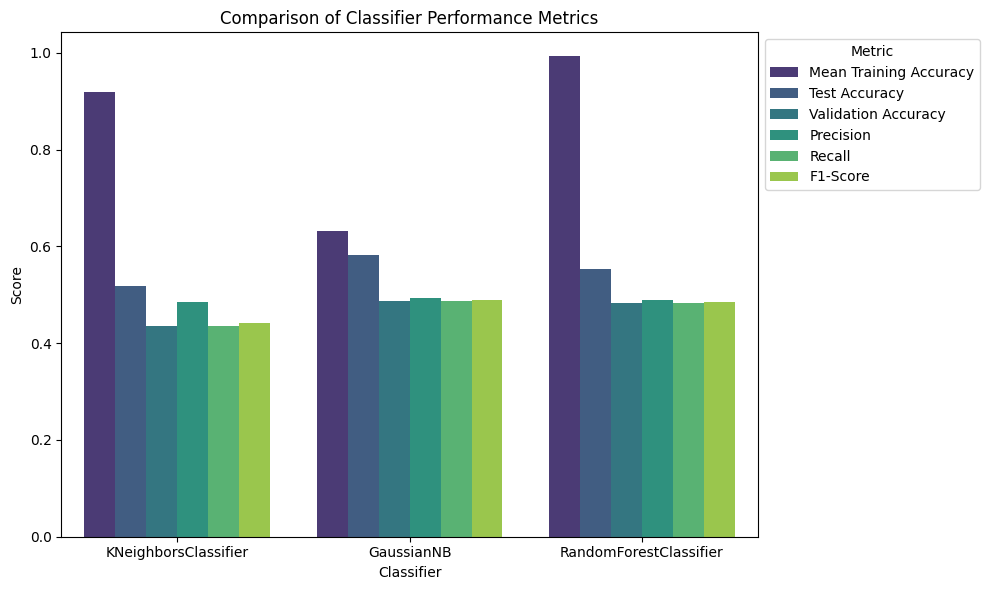

In [55]:
results_melted = Classifiers_df.melt(id_vars="Classifier", var_name="Metric", value_name="Score")

plt.figure(figsize=(10, 6))
sns.barplot(data=results_melted, x="Classifier", y="Score", hue="Metric", palette="viridis")
plt.xlabel("Classifier")
plt.ylabel("Score")
plt.title("Comparison of Classifier Performance Metrics")
plt.legend(title="Metric", loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.show()

### 4.3 Training regressors on CCLE mRNA data and testing their performance <a id="section_4.3"></a>

Note: Select at least three different ML approaches. You can also combine PCA + regressors. 


In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

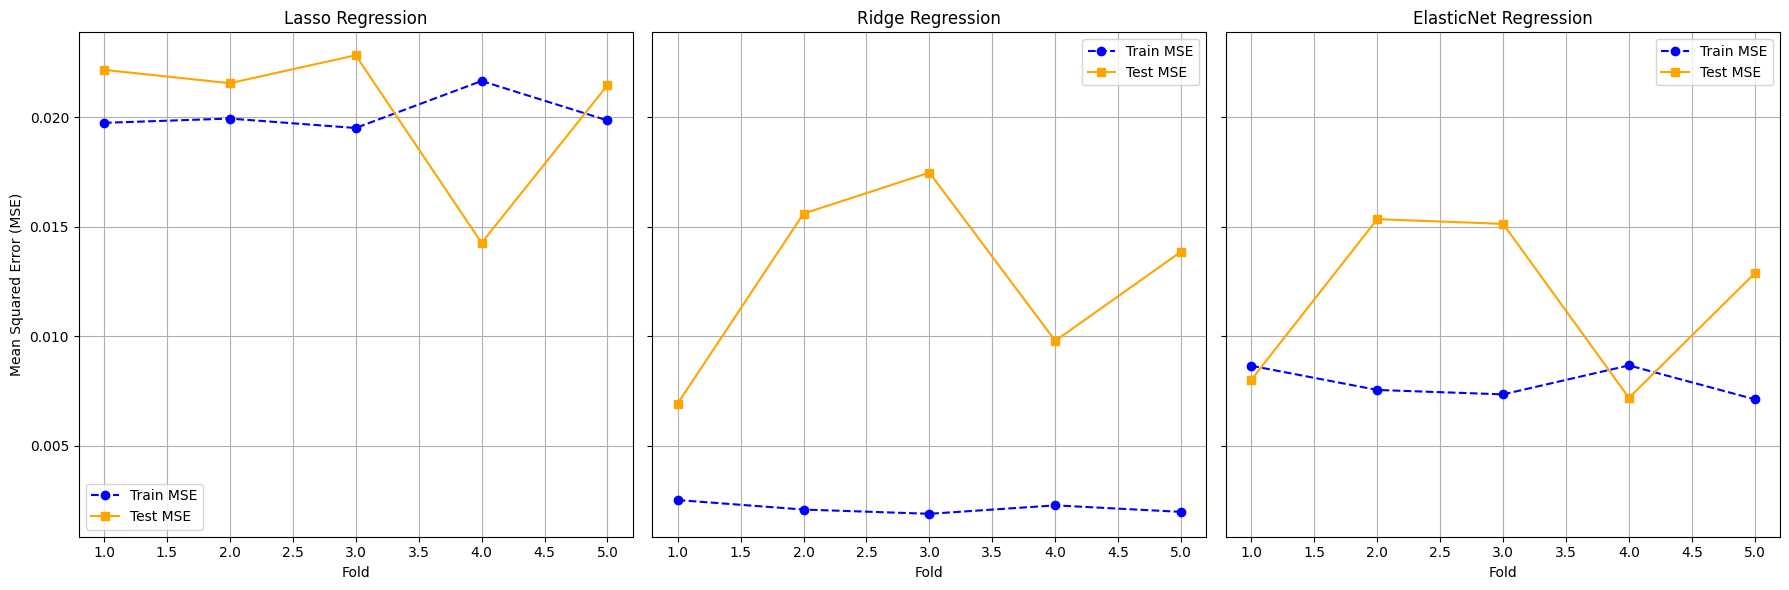

In [57]:
ridge_train_mse = [0.0025168672280860014, 0.002082945565205985, 0.001889050065234417, 0.0022732755520681763, 0.0019767590470012434]
ridge_test_mse = [0.006925483374341283, 0.015597767197739454, 0.017470376931385808, 0.009787740357720677, 0.013863251970190128]
ridge_external = 0.07333634939444875


lasso_train_mse = [0.019742555932987644, 0.01993761577568854, 0.019507266970810323, 0.021653796347176162, 0.019853837090666127]
lasso_test_mse = [0.022163886956247818, 0.02155278959550446, 0.022828821931646936, 0.014261031495654284, 0.021457957560716626]
lasso_external = 0.07709585879187487


elasticnet_train_mse = [0.008648481468373855, 0.007544594104386346, 0.007342958274171991, 0.008665521524391017, 0.007116954760487076]
elasticnet_test_mse = [0.008009314936666024, 0.015344865401125478, 0.015129851029359688, 0.007184431044794402, 0.012876567053904709]
elasticnet_external = 0.07523391259602372

folds = range(1, len(lasso_train_mse) + 1)
#Three subplots with shared y axis.
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

axes[0].plot(folds, lasso_train_mse, marker='o', label='Train MSE', linestyle='--', color='blue')
axes[0].plot(folds, lasso_test_mse, marker='s', label='Test MSE', linestyle='-', color='orange')
axes[0].set_title("Lasso Regression")
axes[0].set_xlabel("Fold")
axes[0].set_ylabel("Mean Squared Error (MSE)")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(folds, ridge_train_mse, marker='o', label='Train MSE', linestyle='--', color='blue')
axes[1].plot(folds, ridge_test_mse, marker='s', label='Test MSE', linestyle='-', color='orange')
axes[1].set_title("Ridge Regression")
axes[1].set_xlabel("Fold")
axes[1].legend()
axes[1].grid(True)

axes[2].plot(folds, elasticnet_train_mse, marker='o', label='Train MSE', linestyle='--', color='blue')
axes[2].plot(folds, elasticnet_test_mse, marker='s', label='Test MSE', linestyle='-', color='orange')
axes[2].set_title("ElasticNet Regression")
axes[2].set_xlabel("Fold")
axes[2].legend()
axes[2].grid(True)


plt.tight_layout()
plt.show()


### 4.4 Analysis of all regressors <a id="section_4.6"></a>

In [60]:
class KFold_CV:
    def __init__(self, k, model, param_grid=None, name="k_fold_cv"):
        self.k = k
        self.model = model
        self.param_grid = param_grid
        self.name = name

    def evaluate(self, training_dataset, testing_dataset, verbose=True):
        fit_results = self.fit(training_dataset, verbose)

        test_X = testing_dataset.filter(like='ENSG', axis=1)
        test_y = testing_dataset['target']

        imp = SimpleImputer(strategy='median')
        pt = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)

        imp.fit(test_X)
        test_X_imputed = imp.transform(test_X)

        pt.fit(test_X_imputed)
        test_X_transformed = pt.transform(test_X_imputed)

        test_X_transformed_df = pd.DataFrame(test_X_transformed)

        test_predictions = self.best_model.predict(test_X_transformed_df)
        test_mse = mean_squared_error(test_y, test_predictions)

        if verbose:
            print(f"Validation MSE: {test_mse}")

        coefficients = self.get_feature_importances(self.best_model)

        return {
            'cross_validation_results': fit_results,
            'external_test_mse': test_mse,
            'coefficients': coefficients 
        }

    def fit(self, dataset, verbose=True):
        self.train_mse_scores = []
        self.test_mse_scores = []
        self.trained_models = []
        self.coefficients = []

        X = dataset.filter(like='ENSG', axis=1)
        y = dataset['target']

        folds_X = np.array_split(X, self.k)
        folds_y = np.array_split(y, self.k)

        for test_fold_i in range(self.k):
            if verbose:
                print(f"{self.name} fold {test_fold_i+1}: ------")

            X_val = folds_X[test_fold_i]
            y_val = folds_y[test_fold_i]
            y_val = pd.DataFrame(y_val)

            X_train = pd.concat([folds_X[i] for i in range(self.k) if i != test_fold_i])
            y_train = pd.concat([folds_y[i] for i in range(self.k) if i != test_fold_i])

            imp = SimpleImputer(strategy='median')
            pt = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)

            imp.fit(X_train)
            X_train_imputed = imp.transform(X_train)
            X_val_imputed = imp.transform(X_val)

            pt.fit(X_train_imputed)
            X_train_transformed = pt.transform(X_train_imputed)
            X_val_transformed = pt.transform(X_val_imputed)

            X_train_transformed_df = pd.DataFrame(X_train_transformed)
            X_val_transformed_df = pd.DataFrame(X_val_transformed)

            grid_search = GridSearchCV(self.model, self.param_grid, scoring='neg_mean_squared_error', cv=3)
            grid_search.fit(X_train_transformed_df, y_train)
            best_model = grid_search.best_estimator_
            self.trained_models.append(best_model)

            y_pred_train = best_model.predict(X_train_transformed_df)
            mse_train = mean_squared_error(y_train, y_pred_train) 

            y_pred_test = best_model.predict(X_val_transformed_df)
            mse_test = mean_squared_error(y_val, y_pred_test)

            if verbose:
                print(f"Fold {test_fold_i+1} Train MSE: {mse_train}")
                print(f"Fold {test_fold_i+1} Test MSE: {mse_test}")

            self.train_mse_scores.append(mse_train)
            self.test_mse_scores.append(mse_test)

            #Store coefficients instead of feature importances for regularization based models.
            coefficients = self.get_feature_importances(best_model)
            self.coefficients.append(coefficients)

        self.best_model = self.trained_models[np.argmin(self.test_mse_scores)]
        if verbose:
            print(f"Best model chosen from cross-validation: {self.best_model}")

        return {
            'train_mse_scores': self.train_mse_scores,
            'test_mse_scores': self.test_mse_scores,
            'trained_models': self.trained_models,
            'best_model': self.best_model,
            'coefficients': self.coefficients
        }

    def get_feature_importances(self, model):
        """
        Extract coefficients if the model supports them.
        """
        if hasattr(model, 'coef_'):
            return model.coef_
        else:
            return None


Summary table for different regressors:

In [61]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

param_grid_lr = {'copy_X': [True,False], 
               'fit_intercept': [True,False], 
               'n_jobs': [1,5,10,15,None], 
               'positive': [True,False]}

In [62]:
kfold_cv_lr = KFold_CV(k=5, model=lr, param_grid=param_grid_lr)
results_lr = kfold_cv_lr.evaluate(ccle, test)
print("Cross-Validation Train MSE Scores:", results_lr['cross_validation_results']['train_mse_scores'])
print("Cross-Validation Test MSE Scores:", results_lr['cross_validation_results']['test_mse_scores'])
print("Best Model from Cross-Validation:", results_lr['cross_validation_results']['best_model'])
print("External Test MSE:", results_lr['external_test_mse'])

c:\Users\bilge\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\bilge\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


k_fold_cv fold 1: ------
Fold 1 Train MSE: 1.577266448868128e-31
Fold 1 Test MSE: 0.013241778575011534
k_fold_cv fold 2: ------
Fold 2 Train MSE: 1.2199323699556654e-31
Fold 2 Test MSE: 0.020422512037543313
k_fold_cv fold 3: ------
Fold 3 Train MSE: 1.930389992679501e-31
Fold 3 Test MSE: 0.026156135885374875
k_fold_cv fold 4: ------
Fold 4 Train MSE: 1.245569850348966e-31
Fold 4 Test MSE: 0.019888626655754423
k_fold_cv fold 5: ------
Fold 5 Train MSE: 3.6577137250257585e-31
Fold 5 Test MSE: 0.020377860751490635
Best model chosen from cross-validation: LinearRegression(n_jobs=1)
Validation MSE: 0.08467652856116345
Cross-Validation Train MSE Scores: [1.577266448868128e-31, 1.2199323699556654e-31, 1.930389992679501e-31, 1.245569850348966e-31, 3.6577137250257585e-31]
Cross-Validation Test MSE Scores: [0.013241778575011534, 0.020422512037543313, 0.026156135885374875, 0.019888626655754423, 0.020377860751490635]
Best Model from Cross-Validation: LinearRegression(n_jobs=1)
External Test MSE: 0

In [65]:
best_model = results_lr['cross_validation_results']['best_model']
coefficients = best_model.coef_

feature_names = test.columns
    
top_10_indices = np.argsort(np.abs(coefficients))[-10:]
print("Top 10 Most Important Features For LinearRegressor:")
for idx in top_10_indices:
    print(f"{feature_names[idx]}: {coefficients[idx]}")


Top 10 Most Important Features For LinearRegressor:
ENSG00000109472: 0.01949160742751285
ENSG00000262420: 0.019980795312385176
ENSG00000113356: -0.020098432427254297
ENSG00000277775: 0.020650420035923645
ENSG00000141543: 0.02095174813453004
ENSG00000111142: -0.021168706901512496
ENSG00000141506: 0.02164405324973023
ENSG00000066044: -0.023989785508361564
ENSG00000141499: 0.030507411483157915
ENSG00000145817: -0.03178839914293241


In [66]:
best_model = results_ridge['cross_validation_results']['best_model']
coefficients = best_model.coef_

feature_names = test.columns
    
top_10_indices = np.argsort(np.abs(coefficients))[-10:]
print("Top 10 Most Important Features For Tuned Ridge:")
for idx in top_10_indices:
    print(f"{feature_names[idx]}: {coefficients[idx]}")


Top 10 Most Important Features For Tuned Ridge:
ENSG00000136159: -0.008089534937290584
ENSG00000167088: -0.008196095306722757
ENSG00000277775: 0.008319589225348398
ENSG00000141543: 0.009245814955029049
ENSG00000109472: 0.009497079782089208
ENSG00000123737: -0.01019880643189478
ENSG00000152455: 0.010375135690762406
ENSG00000262420: 0.011167052804544992
ENSG00000141499: 0.011775386434930714
ENSG00000113356: -0.013212250102731018


In [67]:
best_model = results_elasticnet['cross_validation_results']['best_model']
coefficients = best_model.coef_

feature_names = test.columns
    
top_10_indices = np.argsort(np.abs(coefficients))[-10:]
print("Top 10 Most Important Features for ElasticNet:")
for idx in top_10_indices:
    print(f"{feature_names[idx]}: {coefficients[idx]}")

Top 10 Most Important Features for ElasticNet:
ENSG00000071994: -0.00719350315098232
ENSG00000141543: 0.007258546723457997
ENSG00000122545: 0.007305690059865427
ENSG00000135387: -0.008560010106835875
ENSG00000006625: -0.009079132388871492
ENSG00000146457: 0.009438951950302206
ENSG00000172795: -0.010026298711275344
ENSG00000262420: 0.01198269793290962
ENSG00000113356: -0.014893207191728909
ENSG00000123737: -0.020433609287231355


## Apply Forward Feature Selection:

In [68]:
#Fetch gene information from Ensembl API
import requests

def get_gene_name(ensembl_id):
    url = f"https://rest.ensembl.org/lookup/id/{ensembl_id}?content-type=application/json"
    response = requests.get(url)
    if response.status_code == 200:
        gene_data = response.json()
        return gene_data.get('display_name', None)
    else:
        return None

In [69]:
from sklearn.feature_selection import SequentialFeatureSelector

best_model_lr = results_lr['cross_validation_results']['best_model']
imputer_ = SimpleImputer()
X = ccle.filter(like='ENSG', axis=1)
X = imputer_.fit_transform(X)
y = ccle['target']

selector_lr = SequentialFeatureSelector(
    best_model_lr, 
    n_features_to_select=10,  
    direction='forward',
    scoring='r2',
    cv=kfold_cv_lr.k)

selector_lr.fit(X, y)

selected_features_lr = selector_lr.get_support(indices=True)

print("Selected features for Linear Regression:", selected_features_lr)

X_selected_lr = selector_lr.transform(X)
print("Shape of transformed dataset for LR:", X_selected_lr.shape)


Selected features for Linear Regression: [ 48  76  87 112 178 224 274 295 339 440]
Shape of transformed dataset for LR: (309, 10)


In [70]:
train_features = ccle.drop(columns='Cell_Line')
lr_features = [] #List to fetch gene names from ensemble.
for i in selected_features_lr:
    column_name = train_features.columns[i]
    print(f"The {i}th column name is:", column_name)
    lr_features.append(column_name)


The 48th column name is: ENSG00000085511
The 76th column name is: ENSG00000102738
The 87th column name is: ENSG00000105374
The 112th column name is: ENSG00000111605
The 178th column name is: ENSG00000128519
The 224th column name is: ENSG00000137054
The 274th column name is: ENSG00000146576
The 295th column name is: ENSG00000152495
The 339th column name is: ENSG00000166340
The 440th column name is: ENSG00000265203


In [71]:
best_model_ridge = results_ridge['cross_validation_results']['best_model']
imputer_ = SimpleImputer()
X = ccle.filter(like='ENSG', axis=1)
X = imputer_.fit_transform(X) #Simple impute.
y = ccle['target']

selector_ridge = SequentialFeatureSelector(
    best_model_ridge, 
    n_features_to_select=10,  
    direction='forward',
    scoring='r2',
    cv=kfold_cv_ridge.k)

selector_ridge.fit(X, y)

selected_features_ridge = selector_ridge.get_support(indices=True)

print("Selected features for Linear Regression:", selected_features_ridge)

X_selected_ridge = selector_ridge.transform(X)
print("Shape of transformed dataset for ridge:", X_selected_ridge.shape)

Selected features for Linear Regression: [ 43  48  76 185 274 292 295 353 390 425]
Shape of transformed dataset for ridge: (309, 10)


In [103]:
train_features = ccle.drop(columns='Cell_Line')
ridge_features = [] #List to fetch gene names from ensemble.
for i in selected_features_ridge:
    column_name = train_features.columns[i]
    print(f"The {i}th column name is:", column_name)
    ridge_features.append(column_name)

The 43th column name is: ENSG00000080298
The 48th column name is: ENSG00000085511
The 76th column name is: ENSG00000102738
The 185th column name is: ENSG00000130513
The 274th column name is: ENSG00000146576
The 292th column name is: ENSG00000152217
The 295th column name is: ENSG00000152495
The 353th column name is: ENSG00000168938
The 390th column name is: ENSG00000181458
The 425th column name is: ENSG00000204388


In [77]:
best_model_elasticnet = results_elasticnet['cross_validation_results']['best_model']
imputer_ = SimpleImputer()
X = ccle.filter(like='ENSG', axis=1)
X = imputer_.fit_transform(X) #Simple impute.
y = ccle['target']

selector_elasticnet = SequentialFeatureSelector(
    best_model_elasticnet, 
    n_features_to_select=10,  
    direction='forward',
    scoring='r2',
    cv=kfold_cv_elasticnet.k)

selector_elasticnet.fit(X, y)

selected_features_elasticnet = selector_elasticnet.get_support(indices=True)

print("Selected features for Linear Regression:", selected_features_elasticnet)

X_selected_elasticnet = selector_elasticnet.transform(X)
print("Shape of transformed dataset for elasticnet:", X_selected_elasticnet.shape)

Selected features for Linear Regression: [123 185 295 301 353 368 370 377 390 425]
Shape of transformed dataset for elasticnet: (309, 10)


In [78]:
train_features = ccle.drop(columns='Cell_Line')
elasticnet_features = [] #List to fetch gene names from ensemble.
for i in selected_features_elasticnet:
    column_name = train_features.columns[i]
    print(f"The {i}th column name is:", column_name)
    elasticnet_features.append(column_name)

The 123th column name is: ENSG00000113361
The 185th column name is: ENSG00000130513
The 295th column name is: ENSG00000152495
The 301th column name is: ENSG00000155792
The 353th column name is: ENSG00000168938
The 368th column name is: ENSG00000173482
The 370th column name is: ENSG00000173698
The 377th column name is: ENSG00000176595
The 390th column name is: ENSG00000181458
The 425th column name is: ENSG00000204388


## Fetch names for biomarker gene candidates from Ensembl

## 5. Select biomarkers of drug sensitivity <a id="section_5"></a>

Compare feature importance of models that provide feature weights.

You have learned that certain ML algorithms include an intrinsic capacity of assigning weights to each single features (regularization-based methods and/or ensemble decision trees), based on how useful they are at predicting the target variable. Use these ML models to extract the most informative genes for the regression or the classification task (or both). 

**For regularizationn methods (Ridge, Lasso or Elastic-net)**

In this case the importance of features is based on the absolute value of model coefficients. 

*importance = np.abs(model.coef_)*

**For ensemble strategies based on decision trees**

feature_importances = grid_search.best_estimator_.feature_importances_

*importance = model.feature_importances_*

### 5.1 Compare feature importance using feature weights <a id="section_5.1"></a>

Compare feature importance by using barplots (but first sort the features based on their importance). 

When comparing feature importance try to see whether the same genes appear in top 10-20 ranked genes. This sohuld help you select a very robust set of genes (max 10 genes). 

In [80]:
ense = [
    'ENSG00000109472', 'ENSG00000262420', 'ENSG00000113356', 'ENSG00000277775', 'ENSG00000141543',
    'ENSG00000111142', 'ENSG00000141506', 'ENSG00000066044', 'ENSG00000141499', 'ENSG00000145817'
]
lr_importances = [
    0.01949160742751285, 0.019980795312385176, -0.020098432427254297, 0.020650420035923645, 0.02095174813453004,
    -0.021168706901512496, 0.02164405324973023, -0.023989785508361564, 0.030507411483157915, -0.03178839914293241
]

ridge_gene_names = [
    'ENSG00000136159', 'ENSG00000167088', 'ENSG00000277775', 'ENSG00000141543', 'ENSG00000109472',
    'ENSG00000123737', 'ENSG00000152455', 'ENSG00000262420', 'ENSG00000141499', 'ENSG00000113356'
]
ridge_importances = [
    -0.008089534937290584, -0.008196095306722757, 0.008319589225348398, 0.009245814955029049, 0.009497079782089208,
    -0.01019880643189478, 0.010375135690762406, 0.011167052804544992, 0.011775386434930714, -0.013212250102731018
]

elasticnet_gene_names = [
    'ENSG00000071994', 'ENSG00000141543', 'ENSG00000122545', 'ENSG00000135387', 'ENSG00000006625',
    'ENSG00000146457', 'ENSG00000172795', 'ENSG00000262420', 'ENSG00000113356', 'ENSG00000123737'
]
elasticnet_importances = [
    -0.00719350315098232, 0.007258546723457997, 0.007305690059865427, -0.008560010106835875, -0.009079132388871492,
    0.009438951950302206, -0.010026298711275344, 0.01198269793290962, -0.014893207191728909, -0.020433609287231355
]

# Create DataFrames for each model
lr_df = pd.DataFrame({
    'Linear Regression Gene Names': ense,
    'Linear Regression Importances': lr_importances
})

ridge_df = pd.DataFrame({
    'Ridge Gene Names': ridge_gene_names,
    'Ridge Importances': ridge_importances
})

elasticnet_df = pd.DataFrame({
    'ElasticNet Gene Names': elasticnet_gene_names,
    'ElasticNet Importances': elasticnet_importances
})


combined_df = pd.concat([lr_df, ridge_df, elasticnet_df], axis=1)
print(combined_df)


  Linear Regression Gene Names  Linear Regression Importances  \
0              ENSG00000109472                       0.019492   
1              ENSG00000262420                       0.019981   
2              ENSG00000113356                      -0.020098   
3              ENSG00000277775                       0.020650   
4              ENSG00000141543                       0.020952   
5              ENSG00000111142                      -0.021169   
6              ENSG00000141506                       0.021644   
7              ENSG00000066044                      -0.023990   
8              ENSG00000141499                       0.030507   
9              ENSG00000145817                      -0.031788   

  Ridge Gene Names  Ridge Importances ElasticNet Gene Names  \
0  ENSG00000136159          -0.008090       ENSG00000071994   
1  ENSG00000167088          -0.008196       ENSG00000141543   
2  ENSG00000277775           0.008320       ENSG00000122545   
3  ENSG00000141543           0.0

#### Alternative solution to 'feature importance'

Feature selection can also be implemented by using wrapper techniques. Wrapper techniques are a type of feature selection method that evaluates subsets of features by training a machine learning model on them and measuring its performance. They treat the feature selection process as a search problem, where different subsets of features are tested, and the subset that yields the best model performance is selected.

In [81]:
feature_names = train_features.columns.tolist()
#Pass selecter feature indices
lr_gene_names = [get_gene_name(feature_names[i]) for i in selected_features_lr]
ridge_gene_names = [get_gene_name(feature_names[i]) for i in selected_features_ridge]
elasticnet_gene_names = [get_gene_name(feature_names[i]) for i in selected_features_elasticnet]

gene_names_df = pd.DataFrame({
    'Linear Regression Gene Names': lr_gene_names,
    'Ridge Gene Names': ridge_gene_names,
    'ElasticNet Gene Names': elasticnet_gene_names
})
print(gene_names_df)


  Linear Regression Gene Names Ridge Gene Names ElasticNet Gene Names
0                       MAP3K4             RFX3                  CDH6
1                       MRPS31           MAP3K4                 GDF15
2                         NKG7           MRPS31                 CAMK4
3                        CPSF6            GDF15                DEPTOR
4                      TAS2R16           INTS15                  PPIC
5                       POLR1E           SETBP1                 PTPRM
6                       INTS15            CAMK4                ADGRG2
7                        CAMK4             PPIC               KBTBD11
8                         TPP1          TMEM45A               TMEM45A
9                         RBP3           HSPA1B                HSPA1B


### 5.2 Using GeneCards to interpret genes selected from the best model  <a id="section_5.2"></a>

Use the GeneCards database (https://www.genecards.org/) to shortly describe the selected genes and convert them to gene symbols.

Many other web sources exist which convert ensembl gene ids to gene symbols. 

https://biit.cs.ut.ee/gprofiler/convert

## 6. Clustering mRNA profiles of cancer patients  <a id="section_6"></a>

Use clustering approaches to divide cancer patients (within a specific cancer type) into molecular subgroups based on the transcriptomic profile of gene-based biomarkers that were selected for drug sensitivity prediction. 

In [82]:
coad_path = r"C:\Users\bilge\Downloads\coad_cancer_mrna.csv"

coad_df = pd.read_csv(coad_path)

coad = coad_df.drop(columns=['Unnamed: 0']).copy()

coad.isnull().sum().sum()

0

In [83]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
coad_scaled = scaler.fit_transform(coad)


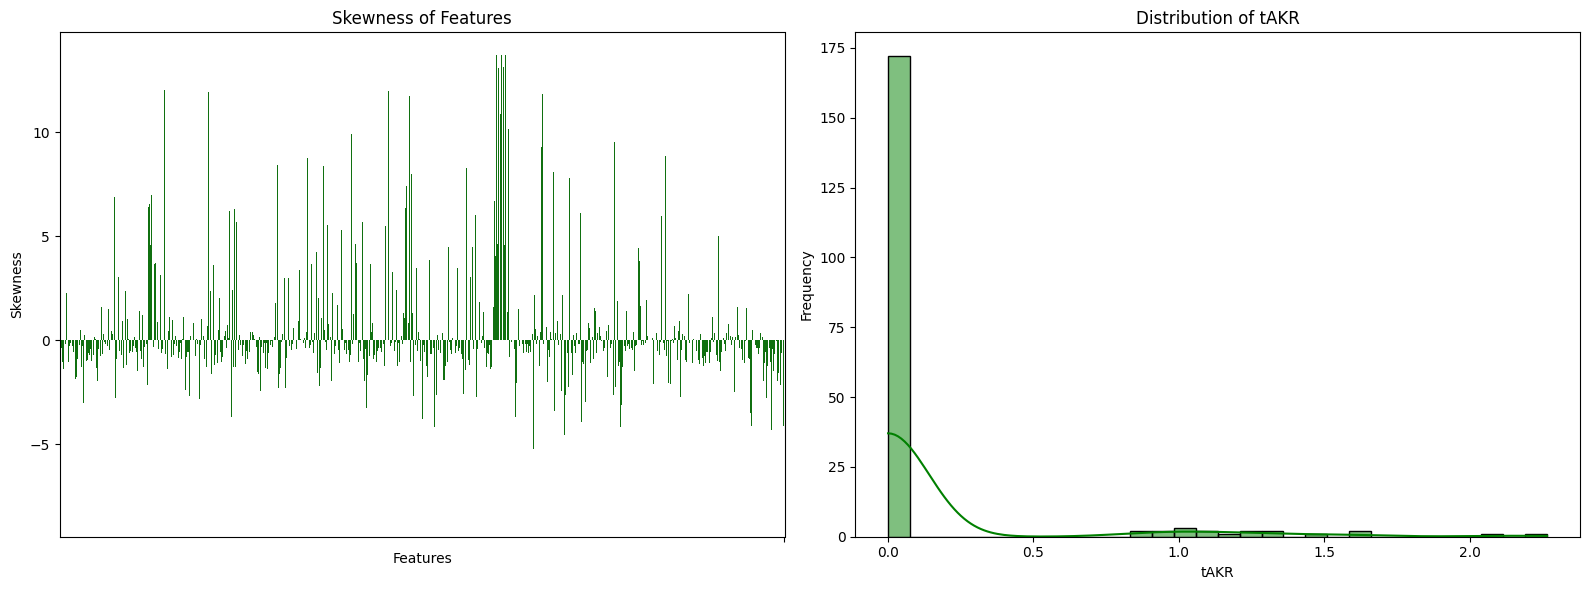

In [84]:
plot_skewness_and_target_distribution(coad, 'tAKR') #The second plot won't be taken into account.

In [85]:
coad

,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
0,4.723449,3.565098,2.846393,7.047503,0.000000,12.294653,7.239883,0.000000,0.000000,10.015493,...,6.576329,8.278902,9.940202,1.349365,8.435467,13.331407,10.237069,8.441903,5.939497,0.0
1,5.947213,4.025614,0.000000,8.261915,0.000000,12.128226,7.153819,1.185169,1.826925,9.901491,...,5.469629,7.962362,9.531096,0.000000,8.974159,12.653240,10.781553,8.736326,5.145470,0.0
2,5.807025,6.951426,0.000000,7.177898,6.905998,12.266624,8.392482,1.188274,2.886336,9.696349,...,6.500071,9.068256,9.929887,1.830864,9.132120,12.467128,9.470537,8.737522,8.467366,0.0
3,5.070278,6.760727,8.198681,7.691165,0.000000,12.101547,6.558733,0.000000,2.787265,10.371226,...,5.139081,7.387758,9.391463,0.000000,8.673556,12.522610,10.477788,9.479993,9.780366,0.0
4,1.168064,7.992528,0.000000,8.111666,1.273337,11.655271,6.801432,0.000000,2.575361,9.834414,...,7.014087,8.889786,9.897940,0.772815,9.983232,11.226873,9.052650,10.353545,7.776419,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,5.895773,6.979676,0.000000,7.825274,0.000000,12.052591,7.554597,0.000000,0.000000,10.646292,...,7.137956,8.305891,10.101470,0.000000,7.154517,13.486990,9.985924,8.512722,4.666268,0.0
187,7.349089,6.368641,6.368641,8.284553,6.687072,11.588418,7.168493,0.000000,0.000000,10.501817,...,7.168493,8.602718,9.876172,0.000000,8.813716,12.092872,10.726965,8.746754,8.355486,0.0
188,4.587887,6.848004,1.578262,7.582222,0.000000,11.963087,7.034407,0.000000,1.578262,10.644579,...,6.365098,8.449397,9.622944,0.000000,8.247357,13.006572,9.031615,8.835448,6.347611,0.0
189,4.814345,7.043729,4.812031,7.979780,1.090040,12.133606,7.392835,1.090040,2.133037,9.803921,...,7.261024,9.054006,9.063168,1.090040,8.705708,11.909857,9.672396,9.725299,6.362340,0.0


In [43]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist
from time import time

### Statistical validation of the separabilirt on the bases of biomarkers:

ENSG00000141499: U-statistic = 3.367686318504227, p-value = 0.000758017877612753
ENSG00000085511: U-statistic = 5.280142229219239, p-value = 1.2908364487511301e-07


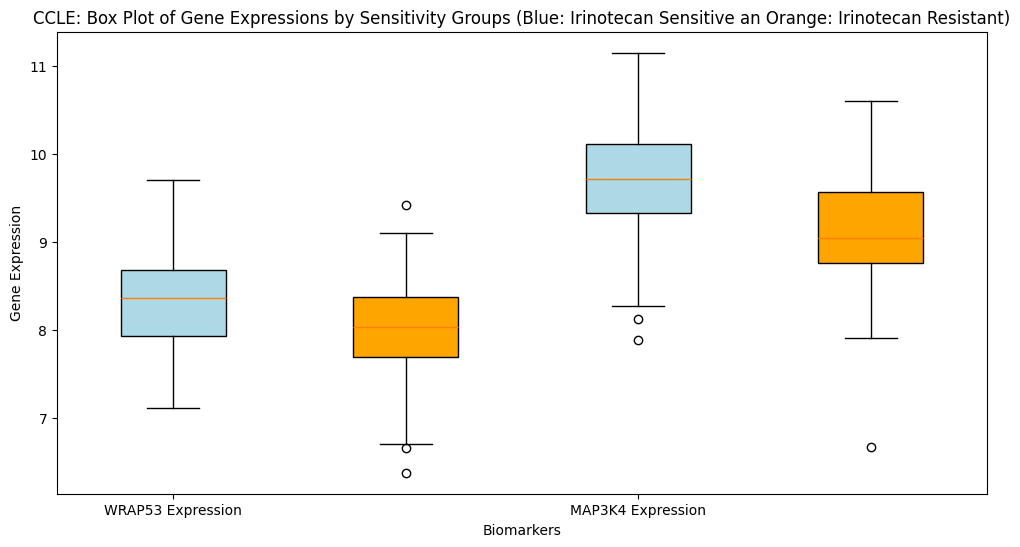

In [86]:
from scipy.stats import ranksums

sensitive = ccle[ccle['sensitivity'] == 2]  # Sensitive group
resistant = ccle[ccle['sensitivity'] == 0]  # Resistant group

Biomarkers = ['ENSG00000141499', 'ENSG00000085511']
wilcoxon_results = {}
labels= ['WRAP53 Expression', 'MAP3K4 Expression']
for gene in Biomarkers:
    sensitive_gene_data = sensitive[gene].dropna()
    resistant_gene_data = resistant[gene].dropna()
    
    stat, p_value = ranksums(sensitive_gene_data, resistant_gene_data)
    
    wilcoxon_results[gene] = {'statistic': stat, 'p_value': p_value}

for gene, result in wilcoxon_results.items():
    print(f"{gene}: U-statistic = {result['statistic']}, p-value = {result['p_value']}")

plt.figure(figsize=(12, 6))
plot_data_sensitive = [sensitive[gene] for gene in Biomarkers]
plot_data_resistant = [resistant[gene] for gene in Biomarkers]

combined_data = []
for data1, data2 in zip(plot_data_sensitive, plot_data_resistant):
    combined_data.append(data1)
    combined_data.append(data2)

colors = ['lightblue', 'orange'] #Represents sensitive, orange resistance

box = plt.boxplot(combined_data, patch_artist=True)

for i, patch in enumerate(box['boxes']):
    patch.set_facecolor(colors[i % 2])

plt.title('CCLE: Box Plot of Gene Expressions by Sensitivity Groups (Blue: Irinotecan Sensitive an Orange: Irinotecan Resistant)')
plt.ylabel('Gene Expression')
plt.xlabel('Biomarkers')
plt.xticks(ticks=range(1, len(Biomarkers) * 2 + 1, 2), labels=labels)
plt.show()


ENSG00000141499: U-statistic = 4.102468616958588, p-value = 4.087653134630845e-05
ENSG00000085511: U-statistic = 4.868439077799108, p-value = 1.1248318792751715e-06


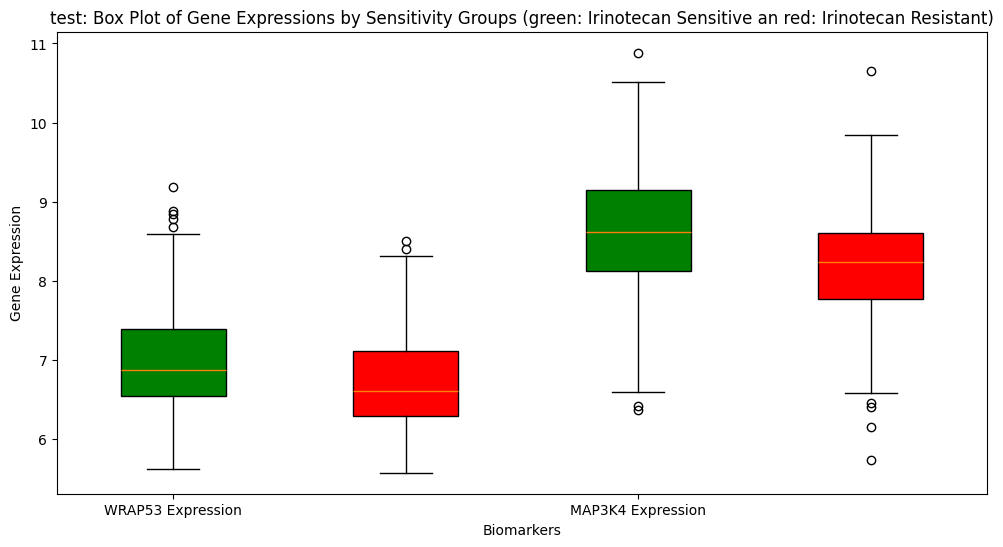

In [93]:
from scipy.stats import ranksums

sensitive = test[test['sensitivity'] == 2]  # Sensitive group
resistant = test[test['sensitivity'] == 0]  # Resistant group

# Candidate Biomarkers
#Biomarkers = ['MAP3K4', 'MRPS31', 'RFX3', 'CAMK4', 'CDH6']
Biomarkers = ['ENSG00000141499', 'ENSG00000085511']
wilcoxon_results = {}
labels= ['WRAP53 Expression', 'MAP3K4 Expression']
for gene in Biomarkers:
    sensitive_gene_data = sensitive[gene].dropna()
    resistant_gene_data = resistant[gene].dropna()
    
    stat, p_value = ranksums(sensitive_gene_data, resistant_gene_data)
    
    wilcoxon_results[gene] = {'statistic': stat, 'p_value': p_value}

for gene, result in wilcoxon_results.items():
    print(f"{gene}: U-statistic = {result['statistic']}, p-value = {result['p_value']}")

plt.figure(figsize=(12, 6))
plot_data_sensitive = [sensitive[gene] for gene in Biomarkers]
plot_data_resistant = [resistant[gene] for gene in Biomarkers]

combined_data = []
for data1, data2 in zip(plot_data_sensitive, plot_data_resistant):
    combined_data.append(data1)
    combined_data.append(data2)

colors = ['green', 'red'] #Represents sensitive, orange resistance

box = plt.boxplot(combined_data, patch_artist=True)

for i, patch in enumerate(box['boxes']):
    patch.set_facecolor(colors[i % 2])

plt.title('test: Box Plot of Gene Expressions by Sensitivity Groups (green: Irinotecan Sensitive an red: Irinotecan Resistant)')
plt.ylabel('Gene Expression')
plt.xlabel('Biomarkers')
plt.xticks(ticks=range(1, len(Biomarkers) * 2 + 1, 2), labels=labels)
plt.show()


In [94]:
coad

,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
0,4.723449,3.565098,2.846393,7.047503,0.000000,12.294653,7.239883,0.000000,0.000000,10.015493,...,6.576329,8.278902,9.940202,1.349365,8.435467,13.331407,10.237069,8.441903,5.939497,0.0
1,5.947213,4.025614,0.000000,8.261915,0.000000,12.128226,7.153819,1.185169,1.826925,9.901491,...,5.469629,7.962362,9.531096,0.000000,8.974159,12.653240,10.781553,8.736326,5.145470,0.0
2,5.807025,6.951426,0.000000,7.177898,6.905998,12.266624,8.392482,1.188274,2.886336,9.696349,...,6.500071,9.068256,9.929887,1.830864,9.132120,12.467128,9.470537,8.737522,8.467366,0.0
3,5.070278,6.760727,8.198681,7.691165,0.000000,12.101547,6.558733,0.000000,2.787265,10.371226,...,5.139081,7.387758,9.391463,0.000000,8.673556,12.522610,10.477788,9.479993,9.780366,0.0
4,1.168064,7.992528,0.000000,8.111666,1.273337,11.655271,6.801432,0.000000,2.575361,9.834414,...,7.014087,8.889786,9.897940,0.772815,9.983232,11.226873,9.052650,10.353545,7.776419,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,5.895773,6.979676,0.000000,7.825274,0.000000,12.052591,7.554597,0.000000,0.000000,10.646292,...,7.137956,8.305891,10.101470,0.000000,7.154517,13.486990,9.985924,8.512722,4.666268,0.0
187,7.349089,6.368641,6.368641,8.284553,6.687072,11.588418,7.168493,0.000000,0.000000,10.501817,...,7.168493,8.602718,9.876172,0.000000,8.813716,12.092872,10.726965,8.746754,8.355486,0.0
188,4.587887,6.848004,1.578262,7.582222,0.000000,11.963087,7.034407,0.000000,1.578262,10.644579,...,6.365098,8.449397,9.622944,0.000000,8.247357,13.006572,9.031615,8.835448,6.347611,0.0
189,4.814345,7.043729,4.812031,7.979780,1.090040,12.133606,7.392835,1.090040,2.133037,9.803921,...,7.261024,9.054006,9.063168,1.090040,8.705708,11.909857,9.672396,9.725299,6.362340,0.0


### 6.2 Compare gene expression trends betwen patient subgroups and sensitive/resistant cancer cell lines <a id="section_6.2"></a>

The biomarkers (or genes) identified through drug sensitivity prediction (biomarkers of drug sensitivity) may help detect specific subgroups of patients for whom the tested drug could be particularly effective.

Each drug is associated with specific cancer types it is intended to treat.


Steps: 

**Identify patient subgroups**: identify cluster patients with at least 10 cancer patients (discard those having a few patients).

**Compare with cell line patterns**: match these subgroups with gene expression patterns observed in drug-sensitive and drug-resistant cancer cell lines.

Build boxplots showing the expression level of these biomarkers within each selected cluster of patients.
Transform drug sensitivity scores into categorical values in pandas (https://www.educative.io/answers/how-to-convert-continuous-values-into-discrete-values-in-pandas).
Build boxplots showing the expression level of the same biomarkers between sensitive and resistant cancer cell lines.

**Guidance for biological interpretation**:

Look for patient clusters that show expression patterns similar to those of sensitive cell lines.
For example, if genes highly expressed in sensitive cell lines are also highly expressed in specific patient clusters, it may suggest that those clusters could respond better to the drug. Make a similar reasoning for the cancer cell lines.

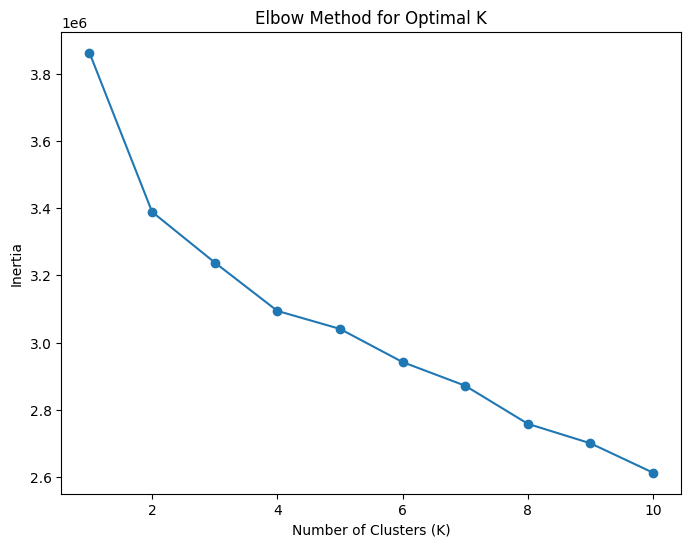

In [102]:
from sklearn.cluster import KMeans

data = coad_numeric
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

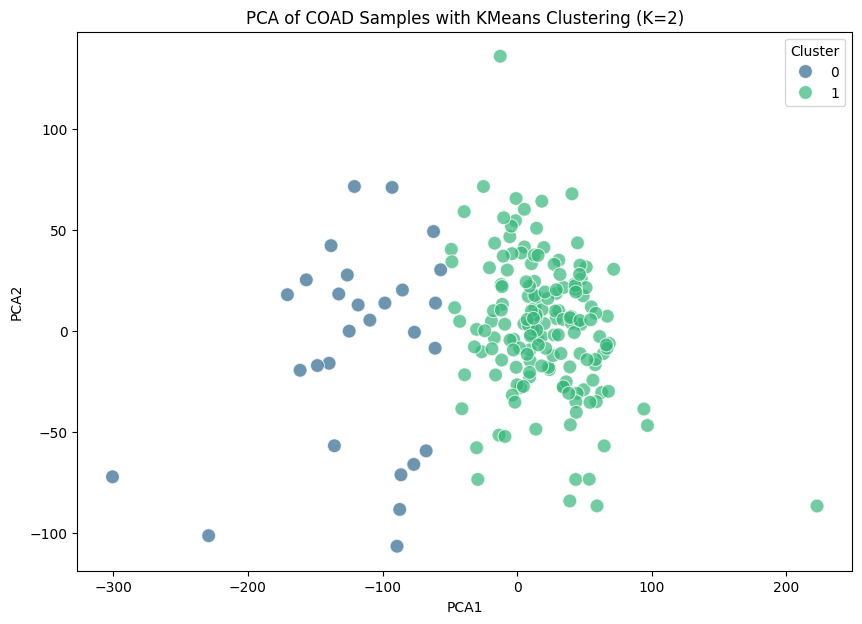

In [103]:
k = 2
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

data['Cluster'] = clusters
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=data['Cluster'], palette='viridis', s=100, alpha=0.7)
plt.title(f'PCA of COAD Samples with KMeans Clustering (K={k})')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()


WRAP53 p-value from Wilcoxon test: 1.72723101119994e-06
MAP3K4 p-value from Wilcoxon test: 0.7799438306838806


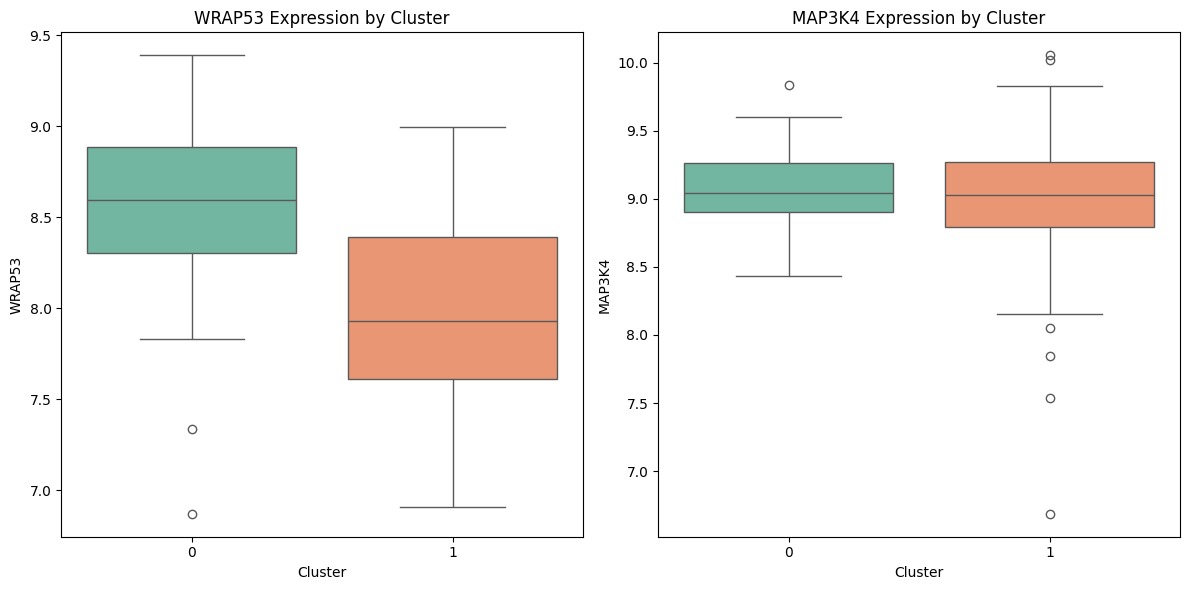

In [104]:
from scipy.stats import mannwhitneyu

mean_expression = data.groupby('Cluster')[['WRAP53', 'MAP3K4']].mean()

#print(mean_expression) 


wrap53_cluster1 = data[data['Cluster'] == 0]['WRAP53']
wrap53_cluster2 = data[data['Cluster'] == 1]['WRAP53']
stat_wrap53, p_value_wrap53 = mannwhitneyu(wrap53_cluster1, wrap53_cluster2)
print(f"WRAP53 p-value from Wilcoxon test: {p_value_wrap53}")

map3k4_cluster1 = data[data['Cluster'] == 0]['MAP3K4']
map3k4_cluster2 = data[data['Cluster'] == 1]['MAP3K4']
stat_map3k4, p_value_map3k4 = mannwhitneyu(map3k4_cluster1, map3k4_cluster2)
print(f"MAP3K4 p-value from Wilcoxon test: {p_value_map3k4}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Cluster', y='WRAP53', data=data, hue='Cluster', palette='Set2', legend=False)
plt.title('WRAP53 Expression by Cluster')

plt.subplot(1, 2, 2)
sns.boxplot(x='Cluster', y='MAP3K4', data=data, hue='Cluster', palette='Set2', legend=False)
plt.title('MAP3K4 Expression by Cluster')

plt.tight_layout()
plt.show()

## 7. Discussion <a id="section_7"></a>
Irinotecan sensitive cancer cell lines were found to express higher levels of a set of candidate biomarker genes, including WRAP53 and MAP3K4, with a statistically significant difference in comparison with irinotecan resistant group.

Then, patient subgroups obtained by unsupervised learning algorithms are compared. The comparison focused on how the expression patterns of WRAP53 and MAP3K4 in the identified patient clusters align with those in cell lines. 

As a result, significant difference in WRAP53 expression between the two clusters (p = 1.73 × $10^{-6}$), with higher expression in Cluster 0. As WRAP53 was found to have an higher expression in irinotecan sensitive cell lines, this cluster may respond better to the drug.

For the case of MAP3K4, no significant difference was found between patient clusters was found (p = 0.78). This suggests that, even though it was an significant factor to distinguish between drug-resistant and drug -sensitive cell line models (figure 10 and 11 in report), it might not be a reliable biomarker for distinguishing between patient subgroups (figure 14 in the report).  

This results indicated the gap between cell line models and human-patient data. Biomarkers that are discovered across cell lines ultimately needs to be validated on patient datasets to confirm their predictive value.  

For a future direction, it could be checked whether the patients in cluster 0 which indicated sensitivity to irinotecan based on higher expression levels of biomarker gene WRAP53 shows better prognosis under treatment.



## 8. References <a id="section_8"></a>

Aho, K. A. (2014). Foundational and Applied Statistics for Biologists (First ed.). Chapman & Hall / CRC Press. ISBN 978-1439873380.
Boehm, B. (n.d.). Yeo-Johnson transformation. Retrieved from https://bradleyboehmke.github.io/HOML/engineering.html
Ghandi, M., Huang, F. W., Jané-Valbuena, J., et al. (2019). Next-generation characterization of the Cancer Cell Line Encyclopedia. Nature, 569(7757), 503–508. https://doi.org/10.1038/s41586-019-1186-3
Espín-Pérez, A., Portier, C., Chadeau-Hyam, M., et al. (2018). Comparison of statistical methods and the use of quality control samples for batch effect correction in human transcriptome data. PLOS ONE, 13(8), e0202947. https://doi.org/10.1371/journal.pone.0202947
Xu, Y., & Villalona-Calero, M. A. (2002). Irinotecan: mechanisms of tumor resistance and novel strategies for modulating its activity. Annals of Oncology, 13(12), 1841–1851. https://doi.org/10.1093/annonc/mdf337
Armand, J. P., Ducreux, M., Mahjoubi, M., et al. (1995). CPT-11 (irinotecan) in the treatment of colorectal cancer. European Journal of Cancer, 31A(7-8), 1283–1287. https://doi.org/10.1016/0959-8049(95)00212-2
Gong, S., Xu, D., Zhu, J., et al. (2018). Efficacy of the MEK inhibitor Cobimetinib and its potential application to colorectal cancer cells. Cell Physiology and Biochemistry, 47(2), 680–693. https://doi.org/10.1159/000490022
Gunasegaran, B., Neilsen, P. M., & Smid, S. D. (2020). P53 activation suppresses irinotecan metabolite SN-38-induced cell damage in non-malignant but not malignant epithelial colonic cells. Toxicology in Vitro, 67, 104908. https://doi.org/10.1016/j.tiv.2020.104908
Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: Concepts, tools, and techniques to build intelligent systems. O’Reilly Media.
Shapiro, S. S., & Wilk, M. B. (1965). "An analysis of variance test for normality (complete samples)." Biometrika, 52(3–4), 591–611. https://doi.org/10.1093/biomet/52.3-4.591
Yeo, I., & Johnson, R. A. (2000). A New Family of Power Transformations to Improve Normality or Symmetry. Biometrika, 87(4), 954–959. https://doi.org/10.1093/biomet/87.4.954
Nusinow, D. P., Szpyt, J., Ghandi, M., et al. (2020). Quantitative proteomics of the Cancer Cell Line Encyclopedia. Nature, 579, 483–489. https://doi.org/10.1038/s41586-019-1413-6
Yang, W., Soares, J., Greninger, P., et al. (2013). Genomics of Drug Sensitivity in Cancer (GDSC): A resource for therapeutic biomarker discovery. Nature, 505, 585–590. https://doi.org/10.1038/nature12966
James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An Introduction to Statistical Learning. UC Berkeley Statistics Department. Retrieved from https://www.stat.berkeley.edu/ISLR_First_Printing

## 9. Additional Information

### A. Evalution of KFold Class

In [105]:
#Base function definition:
def grid_search_cv_with_external_validation(
    dataset_train,  # = CCLE dataset
    dataset_test,   # = GDSC dataset (external validation dataset)
    model,          
    param_grid,     
    k=5,            
    mode="regression",
    metric="mse" 
):
    """
    Performs grid search with k-fold cross-validation and evaluates the model on an external validation set.
    
    Parameters:
        - dataset_train: Training dataset (e.g., CCLE)
        - dataset_test: External validation dataset (e.g., GDSC)
        - model: Model object for training
        - param_grid: Hyperparameter grid for model(s)
        - k: Number of folds for cross-validation
        - task: Task type ("regression" or "classification")
        - metric: Evaluation metric ("mse", "r2", or "auc-roc")
    
    Returns:
        - Dictionary with results for training/test and external validation metrics
    """
    imp = SimpleImputer()
    pt = PowerTransformer(method="yeo-johnson", standardize=False) #Scaling will be enabled at the next step.

    # Prepare train and external validation sets.
    X_train = dataset_train.filter(like='ENSG', axis=1)
    X_test = dataset_test.filter(like='ENSG', axis=1)
    

    if mode == "regression":
        scoring = "neg_mean_squared_error" if metric == "mse" else "r2"
        Y_train = dataset_train['target']
        Y_test = dataset_test['target']
    elif mode == "classification":
        scoring = "roc_auc"
        Y_test = dataset_test['sensitivity']
        Y_train = dataset_test['sensitivity']
    else:
        raise ValueError("Valid modes: 'regression' or 'classification'")

    #Preprocessing of training  data
    #Preprocessors will only be fitted to the the training data.
    X_train_imputed = imp.fit_transform(X_train)
    X_train_transformed = pt.fit_transform(X_train_imputed)
    X_train_df = pd.DataFrame(X_train_transformed, columns=X_train.columns)


    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,
        cv=k,
        return_train_score=True,
        n_jobs=-1 #use all available cpu
    )

    # fit grid_search_CV, gridsearch needs column titles.
    grid_search.fit(X_train_df, Y_train)

    #Extract best parameters.
    best_params = grid_search.best_params_

    mean_train_score = grid_search.cv_results_['mean_train_score'][grid_search.best_index_]
    mean_test_score = grid_search.cv_results_['mean_test_score'][grid_search.best_index_]
    std_train_score = grid_search.cv_results_['std_train_score'][grid_search.best_index_]
    std_test_score = grid_search.cv_results_['std_test_score'][grid_search.best_index_]

    #Preprocessing of external validation set
    #Fitted preprocessors will be only used for transformation
    X_test_imputed = imp.transform(X_test)
    X_test_transformed = pt.transform(X_test_imputed)
    X_test_df = pd.DataFrame(X_test_transformed, columns=X_test.columns)


    
    Y_test_pred = grid_search.best_estimator_.predict(X_test_df)

    
    if metric == "mse":
        external_score = mean_squared_error(Y_test, Y_test_pred)
    elif metric == "r2":
        external_score = r2_score(Y_test, Y_test_pred)
    elif metric == "auc-roc" and mode == "classification":
        external_score = roc_auc_score(Y_test, Y_test_pred)
    else:
        raise ValueError("Valid metrics are: 'mse', 'r2' or 'auc-roc'")

    return pd.DataFrame({
        "Model": [model],
        "Best Parameters": [best_params],
        "CV Train Mean": [mean_train_score],
        "CV Train Std": [std_train_score],
        "CV Test Mean": [mean_test_score],
        "CV Test Std": [std_test_score],
        "External Validation Score": [external_score],
        "Metric": [metric]
    })

In [106]:
#First class definitions:
class KFold_CV:
    def __init__(self, k, model, name="k_fold_cv"):
        """
        Initialize the KFold_CV object.

        Parameters:
        - k (int): Number of folds for cross-validation.
        - model: The machine learning model to be used.
        - name (str): Name of the CV instance (optional).
        """
        self.k = k
        self.model = model
        self.name = name

    def evaluate(self, training_dataset, testing_dataset, verbose = True):
        """
        Performs k-fol CV on training data, and evaluates best model with an external validation dataset.
        """
        #Test data remain unseen by the fit function.
        self.fit(training_dataset, verbose)

        #Evaluate the best model on external validation dataset.

        #Arrange the input.
        test_X = testing_dataset.filter(like='ENSG', axis=1)
        test_y = testing_dataset['target']

        test_predictions = self.model.predict(test_X)
        test_mse = mean_squared_error(test_y, test_predictions) #mse for regression.
        print(f"Test MSE: {test_mse}")

        return np.mean(self.error_scores), test_mse, self.trained_models


    def fit(self,dataset, verbose=True):
        """ 
        Perform k-fold cross-validation for hyperparameter tuning on training data.
        """

        self.error_scores = []
        self.trained_models = []
        self.feature_importances = []


        #When called, the dataset will be specified as training_dataset.
        X = dataset.filter(like='ENSG', axis=1)
        y = dataset['target']

        
        folds_X = np.array_split(X, self.k)
        folds_y = np.array_split(y, self.k)


        for test_fold_i in range(self.k): 
            if verbose:
                print(f"{self.name} fold {test_fold_i+1}: ------")

            #Specify test folds to be left unseen.
            X_val = folds_X[test_fold_i]
            y_val = folds_y[test_fold_i]

            y_val = pd.DataFrame(y_val)

            #Combine the rest of the folds for training.
            X_train = pd.concat([folds_X[i] for i in range(self.k) if i != test_fold_i])
            y_train = pd.concat([folds_y[i] for i in range(self.k) if i != test_fold_i])

            # Preprocessing (imputation and transformation&standardization)
            imp = SimpleImputer()
            pt = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)

            # Fit imputer and transformer on training data
            imp.fit(X_train)
            X_train_imputed = imp.transform(X_train)
            X_val_imputed = imp.transform(X_val)

            pt.fit(X_train_imputed)
            X_train_transformed = pt.transform(X_train_imputed)
            X_val_transformed = pt.transform(X_val_imputed)

            #Ensure model works with proper dataformat : Dataframe (sklearn error base.py 485)
            X_train_transformed_df = pd.DataFrame(X_train_transformed)
            X_val_transformed_df = pd.DataFrame(X_train_transformed)

            #Let the model learn from preprocessed data.
            self.model.fit(X_train_transformed_df, y_train)

            self.trained_models.append(self.model)

            # Make predictions and calculate error
            y_pred = self.model.predict(X_val_transformed)
            mse = mean_squared_error(y_val, y_pred)

            #Print fold-level MSE for debugging and assessing the model stability. 
            print(f"Fold {test_fold_i+1} MSE: {mse}")

            self.error_scores.append(mse)

        if verbose:
            print(f"Mean error across folds: {np.mean(self.error_scores)}")

In [ ]:
#One of the final functions without returning training accuracy
class KFold_CV:
    def __init__(self, k, model, name="k_fold_cv"):
        """
        Initialize the KFold_CV object.

        Parameters:
        - k (int): Number of folds for cross-validation.
        - model: The machine learning model to be used.
        - name (str): Name of the CV instance (optional).
        """
        self.k = k
        self.model = model
        self.name = name

    def evaluate(self, training_dataset, testing_dataset, verbose = True):
        """
        Performs k-fol CV on training data, and evaluates best model with an external validation dataset.
        """
        #Test data remain unseen by the fit function.
        self.fit(training_dataset, verbose)

        #Evaluate the best model on external validation dataset.

        #Arrange the input.
        test_X = testing_dataset.filter(like='ENSG', axis=1)
        test_y = testing_dataset['target']

        test_predictions = self.model.predict(test_X)
        test_mse = mean_squared_error(test_y, test_predictions) #mse for regression.
        print(f"Test MSE: {test_mse}")

        return np.mean(self.error_scores), test_mse, self.trained_models


    def fit(self,dataset, verbose=True):
        """ 
        Perform k-fold cross-validation for hyperparameter tuning on training data.
        """

        self.error_scores = []
        self.trained_models = []
        self.feature_importances = []


        #When called, the dataset will be specified as training_dataset.
        X = dataset.filter(like='ENSG', axis=1)
        y = dataset['target']

        
        folds_X = np.array_split(X, self.k)
        folds_y = np.array_split(y, self.k)


        for test_fold_i in range(self.k): 
            if verbose:
                print(f"{self.name} fold {test_fold_i+1}: ------")

            #Specify test folds to be left unseen.
            X_val = folds_X[test_fold_i]
            y_val = folds_y[test_fold_i]

            y_val = pd.DataFrame(y_val)

            #Combine the rest of the folds for training.
            X_train = pd.concat([folds_X[i] for i in range(self.k) if i != test_fold_i])
            y_train = pd.concat([folds_y[i] for i in range(self.k) if i != test_fold_i])

            # Preprocessing (imputation and transformation&standardization)
            imp = SimpleImputer()
            pt = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)

            # Fit imputer and transformer on training data
            imp.fit(X_train)
            X_train_imputed = imp.transform(X_train)
            X_val_imputed = imp.transform(X_val)

            pt.fit(X_train_imputed)
            X_train_transformed = pt.transform(X_train_imputed)
            X_val_transformed = pt.transform(X_val_imputed)

            #Ensure model works with proper dataformat : Dataframe (sklearn error base.py 485)
            X_train_transformed_df = pd.DataFrame(X_train_transformed)
            X_val_transformed_df = pd.DataFrame(X_train_transformed)

            #Let the model learn from preprocessed data.
            self.model.fit(X_train_transformed_df, y_train)

            self.trained_models.append(self.model)

            # Make predictions and calculate error
            y_pred = self.model.predict(X_val_transformed)
            mse = mean_squared_error(y_val, y_pred)

            #Print fold-level MSE for debugging and assessing the model stability. 
            print(f"Fold {test_fold_i+1} MSE: {mse}")

            self.error_scores.append(mse)

        if verbose:
            print(f"Mean error across folds: {np.mean(self.error_scores)}")


### Attempt to define KFold_CV functioning for both Regression and Classification

In [ ]:
class K_Fold:
    def __init__(self, k, model, param_grid, mode, name="kfold"):
        """
        Initialize the K_Fold_Regressors object.

        Parameters:
        - k (int): Number of folds for cross-validation.
        - model: The machine learning model to be used.
        - param_grid (dict): A dictionary with parameters to search over.
        - mode(str): Valid inputs are 'classification' or 'regression'. 
        - name (str): Name of the CV instance (optional).
        """
        self.k = k
        self.model = model
        self.param_grid = param_grid
        self.mode = mode
        self.name = name
        self.error_scores = []
        self.r2_scores = []
        self.trained_models = []

    def evaluate(self, training_dataset, testing_dataset, verbose=True):
        """
        Performs k-fold CV on training data and evaluates best model with an external validation dataset.
        """
        # Arrange inputs based on the task
        test_X = testing_dataset.filter(like='ENSG', axis=1)

        if self.mode == 'regression':
            test_y = testing_dataset['target']
        elif self.mode == 'classification':
            test_y = testing_dataset['sensitivity']

        # Calls fit to perform k-fold cross-validation with hyperparameter tuning on the training data
        self.fit(training_dataset, verbose=verbose)
        test_predictions = self.model.predict(test_X)

        if self.mode == 'regression':
            test_score_mse = mean_squared_error(test_y, test_predictions)
            test_score_r2 = r2_score(test_y, test_predictions)
            print(f"Test MSE: {test_score_mse}")
            print(f"Test R²: {test_score_r2}")
        elif self.mode == 'classification':
            test_score_accuracy = accuracy_score(test_y, test_predictions)
            print(f"Test Accuracy: {test_score_accuracy}")

        return np.mean(self.error_scores), test_score_accuracy if self.mode == 'classification' else test_score_mse, self.trained_models
    
    def fit(self, dataset, verbose=True):
        """ 
        Perform k-fold cross-validation with grid search on training data.
        """
        X = dataset.filter(like='ENSG', axis=1)

        if self.mode == 'regression':
            y = dataset['target']
            grid_search = GridSearchCV(self.model, self.param_grid, cv=self.k, scoring='neg_mean_squared_error')
        elif self.mode == 'classification':
            y = dataset['sensitivity']
            grid_search = GridSearchCV(self.model, self.param_grid, cv=self.k, scoring='accuracy')

        folds_X = np.array_split(X, self.k)
        folds_y = np.array_split(y, self.k)

        for test_fold_i in range(self.k): 
            
            self.model = clone(self.model) 
            if verbose:
                print(f"Tuning model parameters for candidate {self.name} number {test_fold_i+1}, on inner fold {test_fold_i+1}.")

            # Specify test folds to be left unseen
            X_val = folds_X[test_fold_i]
            y_val = folds_y[test_fold_i]

            # Combine the rest of the folds for training
            X_train = pd.concat([folds_X[i] for i in range(self.k) if i != test_fold_i])
            y_train = pd.concat([folds_y[i] for i in range(self.k) if i != test_fold_i])

            imp = SimpleImputer()
            pt = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)

            imp.fit(X_train)
            X_train_imputed = imp.transform(X_train)
            X_val_imputed = imp.transform(X_val)

            pt.fit(X_train_imputed)
            X_train_transformed = pt.transform(X_train_imputed)
            X_val_transformed = pt.transform(X_val_imputed)

            # Ensure columns are maintained in transformed data
            X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=X.columns)
            X_val_transformed_df = pd.DataFrame(X_val_transformed, columns=X.columns)

            grid_search.fit(X_train_transformed_df, y_train)
            best_model = grid_search.best_estimator_
            self.model = best_model  # Update model with the best one from grid search
            y_pred = best_model.predict(X_val_transformed_df)

            if self.mode == 'regression':
                metric1 = mean_squared_error(y_val, y_pred)
                metric2 = r2_score(y_val, y_pred)
                self.error_scores.append(metric1)
                self.r2_scores.append(metric2)
                print(f"Fold {test_fold_i+1} MSE: {metric1}, R²: {metric2}")
            elif self.mode == 'classification':
                metric3 = accuracy_score(y_val, y_pred)
                self.error_scores.append(metric3)
                print(f"Fold {test_fold_i+1} Accuracy: {metric3}")

            if hasattr(best_model, "feature_importances_"):
                importances = best_model.feature_importances_
            elif hasattr(best_model, "coef_"):
                importances = best_model.coef_.flatten()
            else:
                importances = None

            if importances is not None:
                sorted_indices = np.argsort(importances)[::-1]
                print("\nTop Features:")
                for idx in sorted_indices[:10]:
                    print(f"{X.columns[idx]}: {importances[idx]:.4f}")

        if verbose:
            print(f"Mean error across folds: {np.mean(self.error_scores)}")


In [ ]:
#Without Grid Search CV

class KFold_CV:
    def __init__(self, k, model, name="k_fold_cv"):
        """
        Initialize the KFold_CV object.

        Parameters:
        - k (int): Number of folds for cross-validation.
        - model: The machine learning model to be used.
        - name (str): Name of the CV instance (optional).
        """
        self.k = k
        self.model = model
        self.name = name

    def evaluate(self, training_dataset, testing_dataset, verbose=True):
        """
        Performs k-fold CV on training data, and evaluates best model with an external validation dataset.
        """

        self.fit(training_dataset, verbose)


        test_X = testing_dataset.filter(like='ENSG', axis=1)
        test_y = testing_dataset['target']

        # Preprocessing: Imputation and Transformation + Feature Scaling
        imp = SimpleImputer()
        pt = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)

        # Fit imputer and transformer on training data
        imp.fit(test_X)
        test_X_imputed = imp.transform(test_X)

        pt.fit(test_X_imputed)
        test_X_transformed = pt.transform(test_X_imputed)

        # Ensure correct data format (DataFrame)
        test_X_transformed_df = pd.DataFrame(test_X_transformed)

        # Use the model trained during k-fold CV for prediction on the external test dataset
        test_predictions = self.model.predict(test_X_transformed_df)
        test_mse = mean_squared_error(test_y, test_predictions)

        print(f"Validation MSE: {test_mse}")

        # Return the mean cross-validation error, final test MSE, and the trained models
        return np.mean(self.test_mse_scores), test_mse, self.trained_models, self.train_mse_scores, self.test_mse_scores

    def fit(self, dataset, verbose=True):
        """ 
        Perform k-fold cross-validation for hyperparameter tuning on training data.
        """
        self.train_mse_scores = []
        self.test_mse_scores = []
        self.trained_models = []
        self.feature_importances = []

        X = dataset.filter(like='ENSG', axis=1)
        y = dataset['target']

        # Split dataset into k folds
        folds_X = np.array_split(X, self.k)
        folds_y = np.array_split(y, self.k)

        for test_fold_i in range(self.k): 
            if verbose:
                print(f"{self.name} fold {test_fold_i+1}: ------")

            # Specify test folds to be left unseen.
            X_val = folds_X[test_fold_i]
            y_val = folds_y[test_fold_i]

            y_val = pd.DataFrame(y_val)

            # Combine the rest of the folds for training.
            X_train = pd.concat([folds_X[i] for i in range(self.k) if i != test_fold_i])
            y_train = pd.concat([folds_y[i] for i in range(self.k) if i != test_fold_i])

            # Preprocessing (imputation and transformation&standardization)
            imp = SimpleImputer()
            pt = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)

            # Fit imputer and transformer on training data
            imp.fit(X_train)
            X_train_imputed = imp.transform(X_train)
            X_val_imputed = imp.transform(X_val)

            pt.fit(X_train_imputed)
            X_train_transformed = pt.transform(X_train_imputed)
            X_val_transformed = pt.transform(X_val_imputed)

            # Ensure model works with proper data format: DataFrame (sklearn error base.py 485)
            X_train_transformed_df = pd.DataFrame(X_train_transformed)
            X_val_transformed_df = pd.DataFrame(X_val_transformed)

            # Let the model learn from preprocessed data.
            self.model.fit(X_train_transformed_df, y_train)

            self.trained_models.append(self.model)

            # Make predictions and calculate error
            y_pred_train = self.model.predict(X_train_transformed_df)
            mse_train = mean_squared_error(y_train, y_pred_train)

            y_pred_test = self.model.predict(X_val_transformed_df)
            mse_test = mean_squared_error(y_val, y_pred_test)

            # Print fold-level MSE for debugging and assessing the model stability
            print(f"Fold {test_fold_i+1} Train MSE: {mse_train}")
            print(f"Fold {test_fold_i+1} Test MSE: {mse_test}")

            self.test_mse_scores.append(mse_test)
            self.train_mse_scores.append(mse_train)

        if verbose:
            print(f"Mean Training Error across f-Folds: {np.mean(self.train_mse_scores)}")
            print(f"MSE for Training Folds: {self.train_mse_scores}")
            print(f"Mean Test Error across f-Folds: {np.mean(self.test_mse_scores)}")
            print(f"MSE for Testing Folds: {self.test_mse_scores}")



In [ ]:
class KFold_CV:
    def __init__(self, k, model, name="k_fold_cv"):
        """
        Initialize the KFold_CV object.

        Parameters:
        - k (int): Number of folds for cross-validation.
        - model: The machine learning model to be used.
        - name (str): Name of the CV instance (optional).
        """
        self.k = k
        self.model = model
        self.name = name

    def evaluate(self, training_dataset, testing_dataset, verbose=True):
        """
        Performs k-fold CV on training data, and evaluates best model with an external validation dataset.
        """

        self.fit(training_dataset, verbose)


        test_X = testing_dataset.filter(like='ENSG', axis=1)
        test_y = testing_dataset['target']

        # Preprocessing: Imputation and Transformation + Feature Scaling
        imp = SimpleImputer()
        pt = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)

        # Fit imputer and transformer on training data
        imp.fit(test_X)
        test_X_imputed = imp.transform(test_X)

        pt.fit(test_X_imputed)
        test_X_transformed = pt.transform(test_X_imputed)

        # Ensure correct data format (DataFrame)
        test_X_transformed_df = pd.DataFrame(test_X_transformed)

        # Use the model trained during k-fold CV for prediction on the external test dataset
        test_predictions = self.model.predict(test_X_transformed_df)
        test_mse = mean_squared_error(test_y, test_predictions)

        print(f"Validation MSE: {test_mse}")

        # Return the mean cross-validation error, final test MSE, and the trained models
        return np.mean(self.test_mse_scores), test_mse, self.trained_models, self.train_mse_scores, self.test_mse_scores

    def fit(self, dataset, verbose=True):
        """ 
        Perform k-fold cross-validation for hyperparameter tuning on training data.
        """
        self.train_mse_scores = []
        self.test_mse_scores = []
        self.trained_models = []
        self.feature_importances = []

        X = dataset.filter(like='ENSG', axis=1)
        y = dataset['target']

        # Split dataset into k folds
        folds_X = np.array_split(X, self.k)
        folds_y = np.array_split(y, self.k)

        for test_fold_i in range(self.k): 
            if verbose:
                print(f"{self.name} fold {test_fold_i+1}: ------")

            # Specify test folds to be left unseen.
            X_val = folds_X[test_fold_i]
            y_val = folds_y[test_fold_i]

            y_val = pd.DataFrame(y_val)

            # Combine the rest of the folds for training.
            X_train = pd.concat([folds_X[i] for i in range(self.k) if i != test_fold_i])
            y_train = pd.concat([folds_y[i] for i in range(self.k) if i != test_fold_i])

            # Preprocessing (imputation and transformation&standardization)
            imp = SimpleImputer()
            pt = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)

            # Fit imputer and transformer on training data
            imp.fit(X_train)
            X_train_imputed = imp.transform(X_train)
            X_val_imputed = imp.transform(X_val)

            pt.fit(X_train_imputed)
            X_train_transformed = pt.transform(X_train_imputed)
            X_val_transformed = pt.transform(X_val_imputed)

            # Ensure model works with proper data format: DataFrame (sklearn error base.py 485)
            X_train_transformed_df = pd.DataFrame(X_train_transformed)
            X_val_transformed_df = pd.DataFrame(X_val_transformed)

            # Let the model learn from preprocessed data.
            self.model.fit(X_train_transformed_df, y_train)

            self.trained_models.append(self.model)

            # Make predictions and calculate error
            y_pred_train = self.model.predict(X_train_transformed_df)
            mse_train = mean_squared_error(y_train, y_pred_train)

            y_pred_test = self.model.predict(X_val_transformed_df)
            mse_test = mean_squared_error(y_val, y_pred_test)

            # Print fold-level MSE for debugging and assessing the model stability
            print(f"Fold {test_fold_i+1} Train MSE: {mse_train}")
            print(f"Fold {test_fold_i+1} Test MSE: {mse_test}")

            self.test_mse_scores.append(mse_test)
            self.train_mse_scores.append(mse_train)

        if verbose:
            print(f"Mean Training Error across f-Folds: {np.mean(self.train_mse_scores)}")
            print(f"MSE for Training Folds: {self.train_mse_scores}")
            print(f"Mean Test Error across f-Folds: {np.mean(self.test_mse_scores)}")
            print(f"MSE for Testing Folds: {self.test_mse_scores}")

#Regressor without gridsearch cv


In [ ]:

data_regs = {
    "Regressor": ["Linear Regression", "Ridge Regression", "Lasso Regression", "ElasticNet"],
    "Mean Train MSE": [1.9714856201473964e-31, 3.083546900768189e-06, 0.02013901442346576, 0.02013901442346576],
    "Mean Test MSE": [0.020726582971339547, 0.020270494572538277, 0.020452897507954027, 0.020452897507954027],
    "Validation MSE": [0.08712374667917093, 0.08656383330733897, 0.07790985514068097, 0.07790985514068097]
}

df_regs = pd.DataFrame(data_regs)
print(df_regs)

results_melted = df_regs.melt(id_vars="Regressor", var_name="Metric", value_name="Score")

plt.figure(figsize=(10, 6))
sns.barplot(data=results_melted, x="Regressor", y="Score", hue="Metric", palette="viridis")

plt.xlabel("Regressor")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Comparison of Regression Performance Metrics")
plt.legend(title="Metric", loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.show()